# Inferring Timing Properties using SBI

We want to accurately infer timing properties of stochastic light curves in X-rays 
under the presence of dead time. Dead time has the problem that we can't really write a good model 
down for it for any given light curve, because it depends on the flux at any given moment, which is 
a stochastic process for the cases we are considering. 

However, *simulating* dead time is fairly straightforward, if the dead time process of the instrument 
is reasonably well known. Here, we're going to use simulation-based inference as implemented in the 
`sbi` package to try and infer properties of a QPO in a single periodogram:

In [104]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=8)

import numpy as np
import pandas as pd
from tqdm import tnrange, tqdm_notebook

import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm_notebook, tnrange 
import numba
from numba import jit, njit

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator
from stingray.events import EventList

import warnings
warnings.filterwarnings('ignore')

from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst
from stingray import filters



In [98]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

In [3]:
@jit
def lorentzian(x, amp, x0, fwhm):
    fac1 = amp * (fwhm/2)**2.
    fac2 = (fwhm/2)**2. + (x - x0)**2.
    return fac1/fac2

@jit(nopython=True)
def extract_and_scale(long_lc, red_noise, npoints, mean_counts, rms):
    """
    i) Make a random cut and extract a light curve of required
    length.

    ii) Rescale light curve i) with zero mean and unit standard
    deviation, and ii) user provided mean and rms (fractional
    rms * mean)

    Parameters
    ----------
    long_lc : numpy.ndarray
        Simulated lightcurve of length 'npoints' times 'red_noise'
    
    red_noise : float
        A multiplication factor for the length of the light curve, 
        to deal with red noise leakage
    
    npoints : int
        The total number of data points in the light curve
        
    mean_counts : float
        The mean counts per bin of the light curve to be 
        simulated
        
    rms : float [0, 1]
        The fractional rms amplitude of the variability in the 
        light curve.

    Returns
    -------
    lc : numpy.ndarray
        Normalized and extracted lightcurve of lengtha 'N'
    """
    if red_noise == 1:
        lc = long_lc
    else:
        # Make random cut and extract light curve of length 'N'
        extract = \
            np.random.randint(npoints-1,
                                      red_noise*npoints - npoints+1)
        lc = np.take(long_lc, np.arange(extract, extract + npoints))

    avg = np.mean(lc)
    std = np.std(lc)

    return (lc-avg)/std * mean_counts * rms + mean_counts


@jit(nopython=False)
def simulate_lc(mspec, dt, npoints, mean_counts, rms, tstart = 0.0, red_noise=1.0):
    """
    
    
    
    """

    time = dt*np.arange(npoints) + tstart

    a1 = np.random.normal(size=(2,len(mspec))) * np.sqrt(mspec)

    f = a1[0] + 1j * a1[1]

    f[0] = mean_counts

    # Obtain real valued time series
    f_conj = np.conjugate(np.array(f))

    cts = np.fft.irfft(f_conj, n=npoints)

    lc = Lightcurve(time, extract_and_scale(cts, red_noise, npoints, mean_counts, rms),
                err=np.zeros_like(time) + np.sqrt(mean_counts),
                err_dist='gauss', dt=dt, skip_checks=True)

    return lc

@jit(nopython=True)
def generate_events(time, counts1, counts2):

    cs1 = np.cumsum(counts1)
    cs2 = np.cumsum(counts2)

    times1 = np.zeros(cs1[-1])
    times2 = np.zeros(cs2[-1])

    ncounts = len(counts1)

    for i in range(ncounts):
        times1[cs1[i]:cs1[i+1]] = time[i]
        times2[cs2[i]:cs2[i+1]] = time[i]
        
    return times1, times2

In [4]:
@jit(nopython=False)
def simulate_deadtime(param, freq=None, tseg=10.0, dt_hires=1e-5, dt=0.005, deadtime=0.0025):
    #print("starting function")
    qpo_amp = 1.0 # amplitude of the QPO in CSD
    qpo_rms = param[0] # absolute rms amplitude of the QPO
    qpo_x0 = param[1] # centroid position of the PSD
    qpo_qual = param[2] # quality factor for the QPO
    qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
    mean_cr = param[3] # mean count rate in the light curve

    npoints = int(np.round(tseg/dt_hires)) # total number of points in original light curve

    # count rate in nustar bins
    mean_cr_hires = mean_cr * dt_hires

    if freq is None:
        df_hires = 1.0/tseg # frequency resolution of the PSD/CSD
        fmax_hires = 0.5/dt_hires # maximum frequency in the CSD/PSD

        # list of frequencies
        freq = np.arange(df_hires, fmax_hires+df_hires, df_hires)

    # generate theoretical spectrum
    mspec = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

    #print("simulating light curves")
    lc = simulate_lc(mspec, dt_hires, npoints, mean_cr_hires, qpo_rms)
    lc.counts[lc.counts < 0] = 0.0

    #print("applying counts")
    # apply counts
    counts1 = np.random.poisson(lc.counts)
    counts2 = np.random.poisson(lc.counts)

    counts_total = counts1 + counts2

    #print("generating events")
    times1, times2 = generate_events(lc.time, counts1, counts2)

    #print("deadtime filtering")
    mask1 = filters.get_deadtime_mask(times1, deadtime, return_all=False)
    mask2 = filters.get_deadtime_mask(times2, deadtime, return_all=False)

    times1_dt = times1[mask1]
    times2_dt = times2[mask2]
    
    #print("generating light curves")
    lc1 = Lightcurve.make_lightcurve(times1, dt=dt, tseg=tseg, tstart=0.0)
    lc1_dt = Lightcurve.make_lightcurve(times1_dt, dt=dt, tseg=tseg, tstart=0.0)

    lc2 = Lightcurve.make_lightcurve(times2, dt=dt, tseg=tseg, tstart=0.0)
    lc2_dt = Lightcurve.make_lightcurve(times2_dt, dt=dt, tseg=tseg, tstart=0.0)

    #lc_sim = lc1 + lc2
    #lc_sim_dt = lc1_dt + lc2_dt

    #print("generating PSDS")
    #ps_sim = Powerspectrum(lc_sim, norm="frac")
    #ps_sim_dt = Powerspectrum(lc_sim_dt, norm="frac")

    #cs_sim = Crossspectrum(lc1, lc2, norm="frac")
    #cs_sim_dt = Crossspectrum(lc1_dt, lc2_dt, norm="frac")

    #print("... and done")
    return lc1, lc2, lc1_dt, lc2_dt

Okay, those are my basic functions. I probably need to turn them into pytorch tensors, but let's keep working with what we have for now. Let's make some data:

In [50]:
np.random.seed(20201204)

qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 20.0 # centroid frequency of the QPO, in Hz
qpo_qual = 10.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.4 # fractional RMS amplitude of the QPO

tseg = 10.0 # total duration in seconds
dt_nustar = 1e-5 # time resolution of NuSTAR
dt = 0.005 # time step of the output light curve
npoints = int(np.round(tseg/dt_nustar)) # total number of points in original light curve

mean_countrate_obs = 1000
mean_counts_nustar_obs = mean_countrate_obs * dt_nustar

df_nustar = 1.0/tseg # frequency resolution of the PSD/CSD
fmax_nustar = 0.5/dt_nustar # maximum frequency in the CSD/PSD

# dead time for nustar
deadtime_nustar = 0.0025

# list of frequencies
freq = np.linspace(df_nustar, fmax_nustar, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

# store parameters in a list for easy (plotting) access
param_obs = [rms_obs, qpo_x0, qpo_qual, mean_countrate_obs]

# generate some ligth curves, both with (*_dt) and without dead time
lc1_obs, lc2_obs, lc1_obs_dt, lc2_obs_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)

Let's make both PSDs and CSDs of the light curves, and then plot both the light curves, PSDs and CSDs

In [51]:
lc_obs = lc1_obs + lc2_obs
lc_obs_dt = lc1_obs_dt + lc2_obs_dt

ps_obs = Powerspectrum(lc_obs, norm="frac")
ps_obs_dt = Powerspectrum(lc_obs_dt, norm="frac")

cs_obs = Crossspectrum(lc1_obs, lc2_obs, norm="frac")
cs_obs_dt = Crossspectrum(lc1_obs_dt, lc2_obs_dt, norm="frac")

In [105]:
sns.color_palette()

[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

<IPython.core.display.Javascript object>


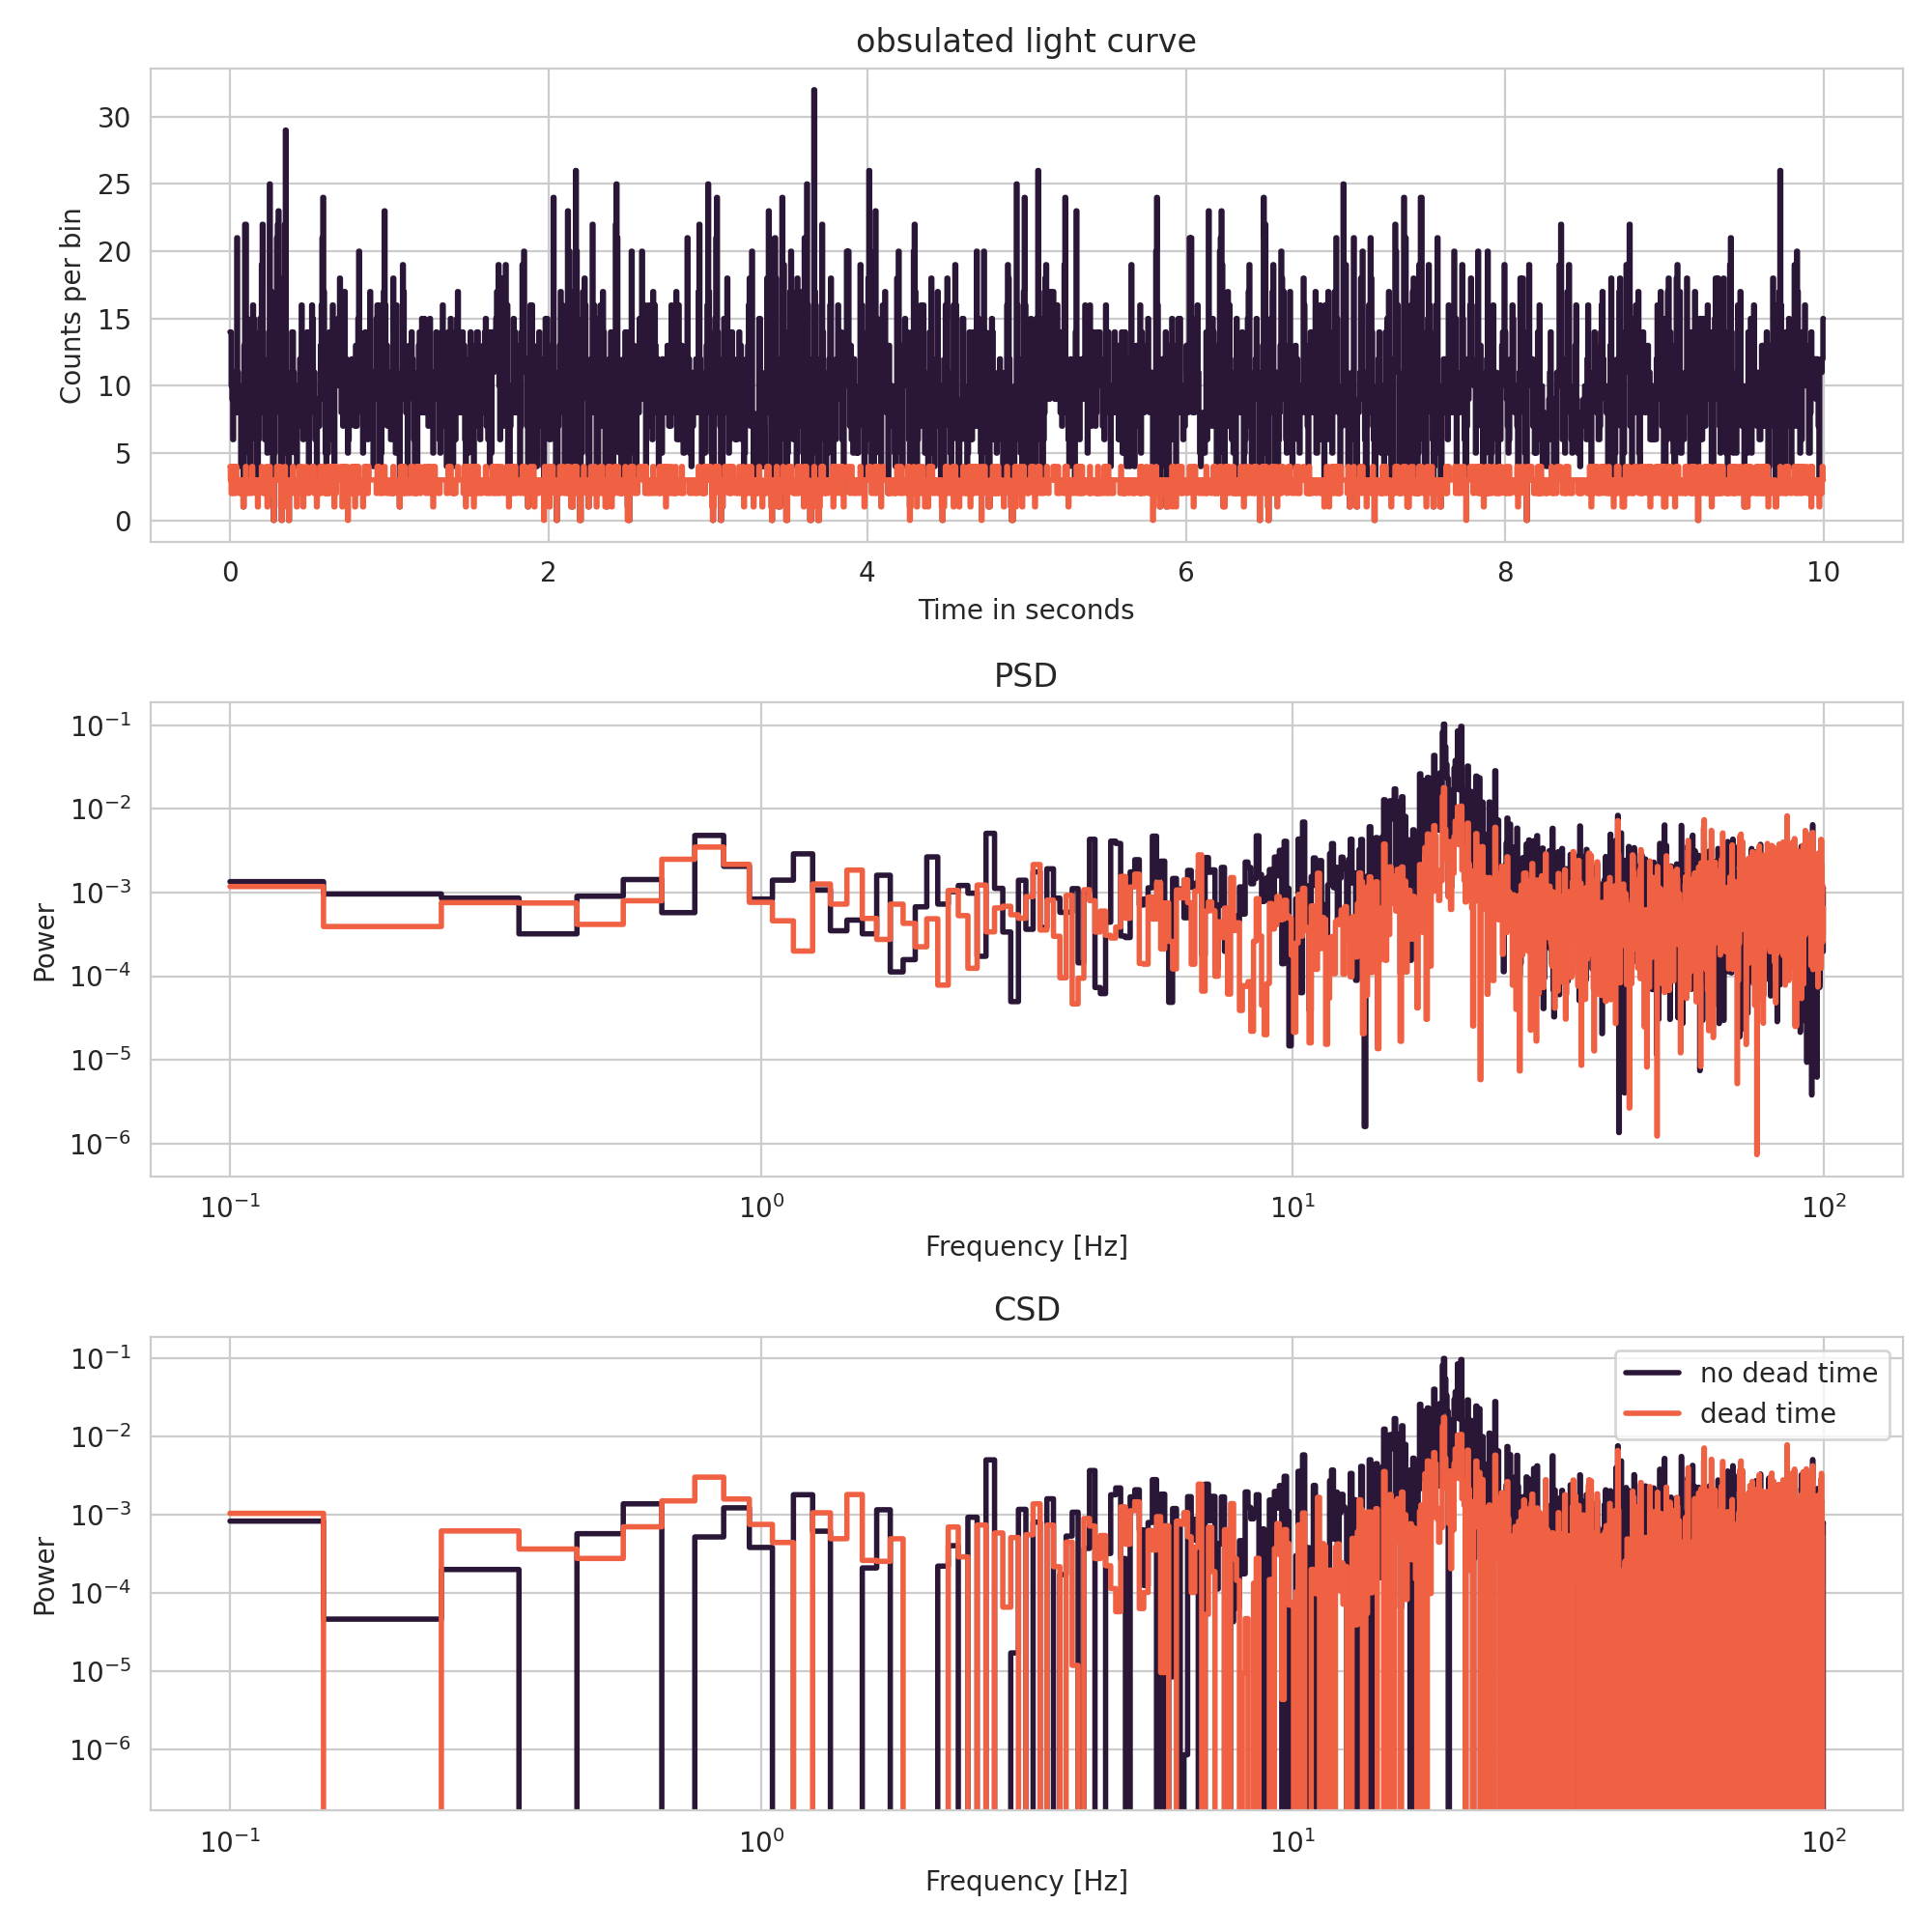

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]

ax1.plot(lc_obs.time, lc_obs.counts, ds="steps-mid", lw=2, label="no dead time", c=c1)
ax1.plot(lc_obs_dt.time, lc_obs_dt.counts, ds="steps-mid", lw=2, label="dead time", c=c2)
ax1.set_xlabel("Time in seconds")
ax1.set_ylabel("Counts per bin")
ax1.set_title("obsulated light curve")

ax2.loglog(ps_obs.freq, ps_obs.power, lw=2, ds="steps-mid", label="no dead time", c=c1)
ax2.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, ds="steps-mid", label="dead time", c=c2)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power")
ax2.set_title("PSD")

ax3.loglog(cs_obs.freq, cs_obs.power, lw=2, ds="steps-mid", label="no dead time", c=c1)
ax3.loglog(cs_obs_dt.freq, cs_obs_dt.power, lw=2, ds="steps-mid", label="dead time", c=c2)
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Power")
ax3.set_title("CSD")

ax3.legend()

plt.tight_layout()

Now we can set up our simulation-based inference. First, we need a function that takes a set of parameters as input, and then returns some form of data we want to compare, in our case the periodogram powers directly:

In [259]:

def generate_simulator_function(tseg=10.0, dt_hires=1e-5, dt=0.005, 
                                deadtime=0.0025, segment_size=1.0, summary_type="psd", f=0.01):
    def simulation(param):
        """
        Generate a simulated data set with a single QPO given a parameter set.

        Parameters
        ----------
        param : iterable
            A list of parameters:
                * Fractional RMS amplitude of the QPO
                * centroid position x0 of teh QPO
                * quality factor (x0/fwhm) of the QPO
                * average count rate of the light curve

        summary_type:
            What to return as a summary. Options are
                * "psd": return the unaveraged powers in the PSD
                * "avg": return averaged PSD, requires `segment_size`

        Returns
        -------
        summary : np.ndarray
            An array of summary statistics

        """

        param = np.array(param)
        #param = [rms, x0, qual, mean_cr]
        qpo_rms = param[0] # absolute rms amplitude of the QPO
        qpo_x0 = param[1] # centroid position of the PSD
        qpo_qual = param[2] # quality factor for the QPO
        qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
        mean_cr = param[3] # mean count rate in the light curve


        lc1, lc2, lc1_dt, lc2_dt = simulate_deadtime(param, 
                                                     freq=None, 
                                                     tseg=tseg, 
                                                     dt_hires=dt_hires, 
                                                     dt=dt, 
                                                     deadtime=deadtime)


        if summary_type == "psd":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            return torch.as_tensor(ps.power)
        elif summary_type == "avg":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, norm="frac")
            return torch.as_tensor(aps.power)
        elif summary_type == "csd":
            cs = Crossspectrum(lc1_dt, lc2_dt, norm="frac")
            return torch.as_tensor(cs.power)
        elif summary_type == "logbin":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            ps_bin = ps.rebin_log(f)
            return torch.as_tensor(ps_bin.power)
        elif summary_type == "avglogbin":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, 
                                        norm="frac", silent=True)
            aps_bin = aps.rebin_log(f)
            return torch.as_tensor(aps_bin.power)
        else:
            raise ValueError("Type of summary to be returned not recognized!")
            
    return simulation

Next, we need to set up priors. We're going to make some assumptions about what values are reasonable:

In [12]:
lower_bounds = torch.tensor([0.1, 5.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 40.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )

Okay, let's see if we can actually run the neural network emulation. Here's a dictionary with the keyword argument for the simulator:

In [39]:
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.005, "deadtime":0.0025, "summary_type":"psd"}

Now we can generate a simulator function to use in the SBI interface:

In [40]:
simulator = generate_simulator_function(**simulation_kwargs)

Let's give it a try, just to be sure:

In [41]:
test_data = simulator(param_obs)

In [42]:
test_data[:10]

tensor([1.7882e-03, 4.6341e-05, 1.1548e-04, 1.2838e-03, 1.1576e-04, 1.8031e-03,
        8.0403e-04, 1.4043e-03, 5.6596e-04, 2.6521e-04], dtype=torch.float64)

Ok, cool. Now, we're going to run the inference interface to build a model for the posterior:


Neural network successfully converged after 26 epochs.


<IPython.core.display.Javascript object>


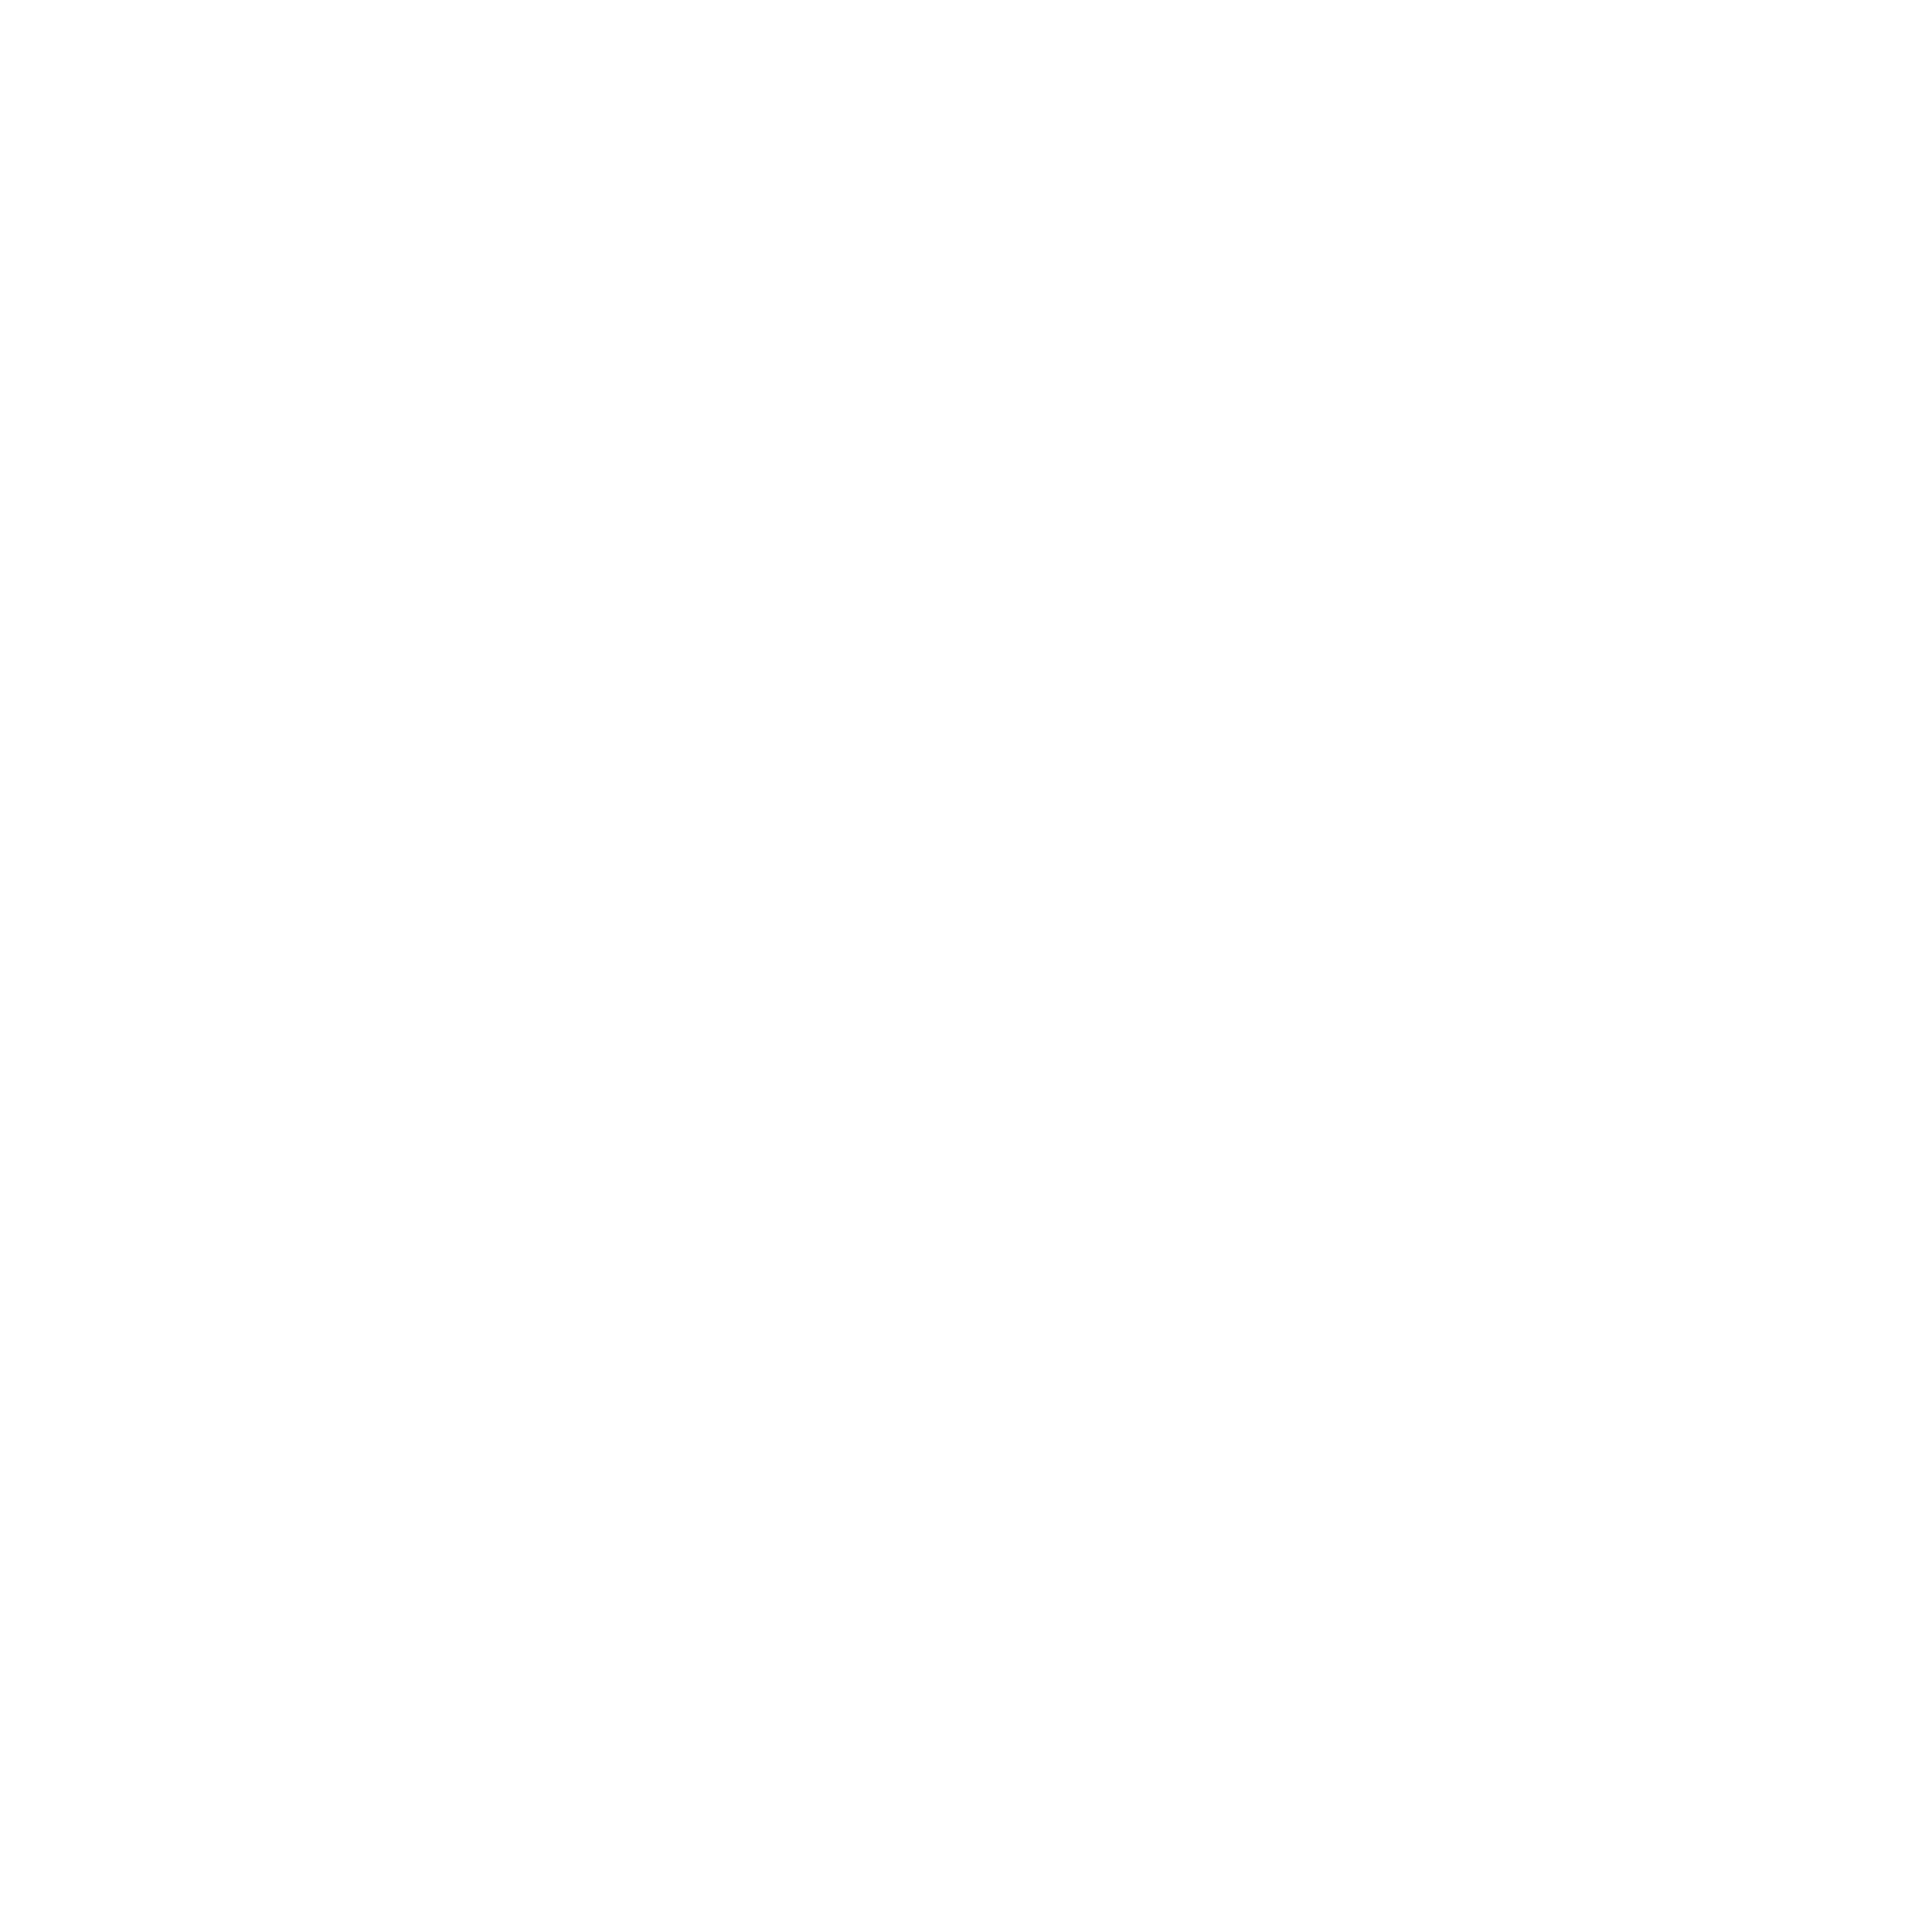

In [56]:
num_sim = 5000
method = "SNPE"

posterior = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

Now we can sample from there:

In [60]:
samples = posterior.sample((2000,), 
                           x=torch.as_tensor(ps_obs_dt.power))

In [61]:
param_obs

[0.4, 20.0, 10.0, 1000]

<IPython.core.display.Javascript object>


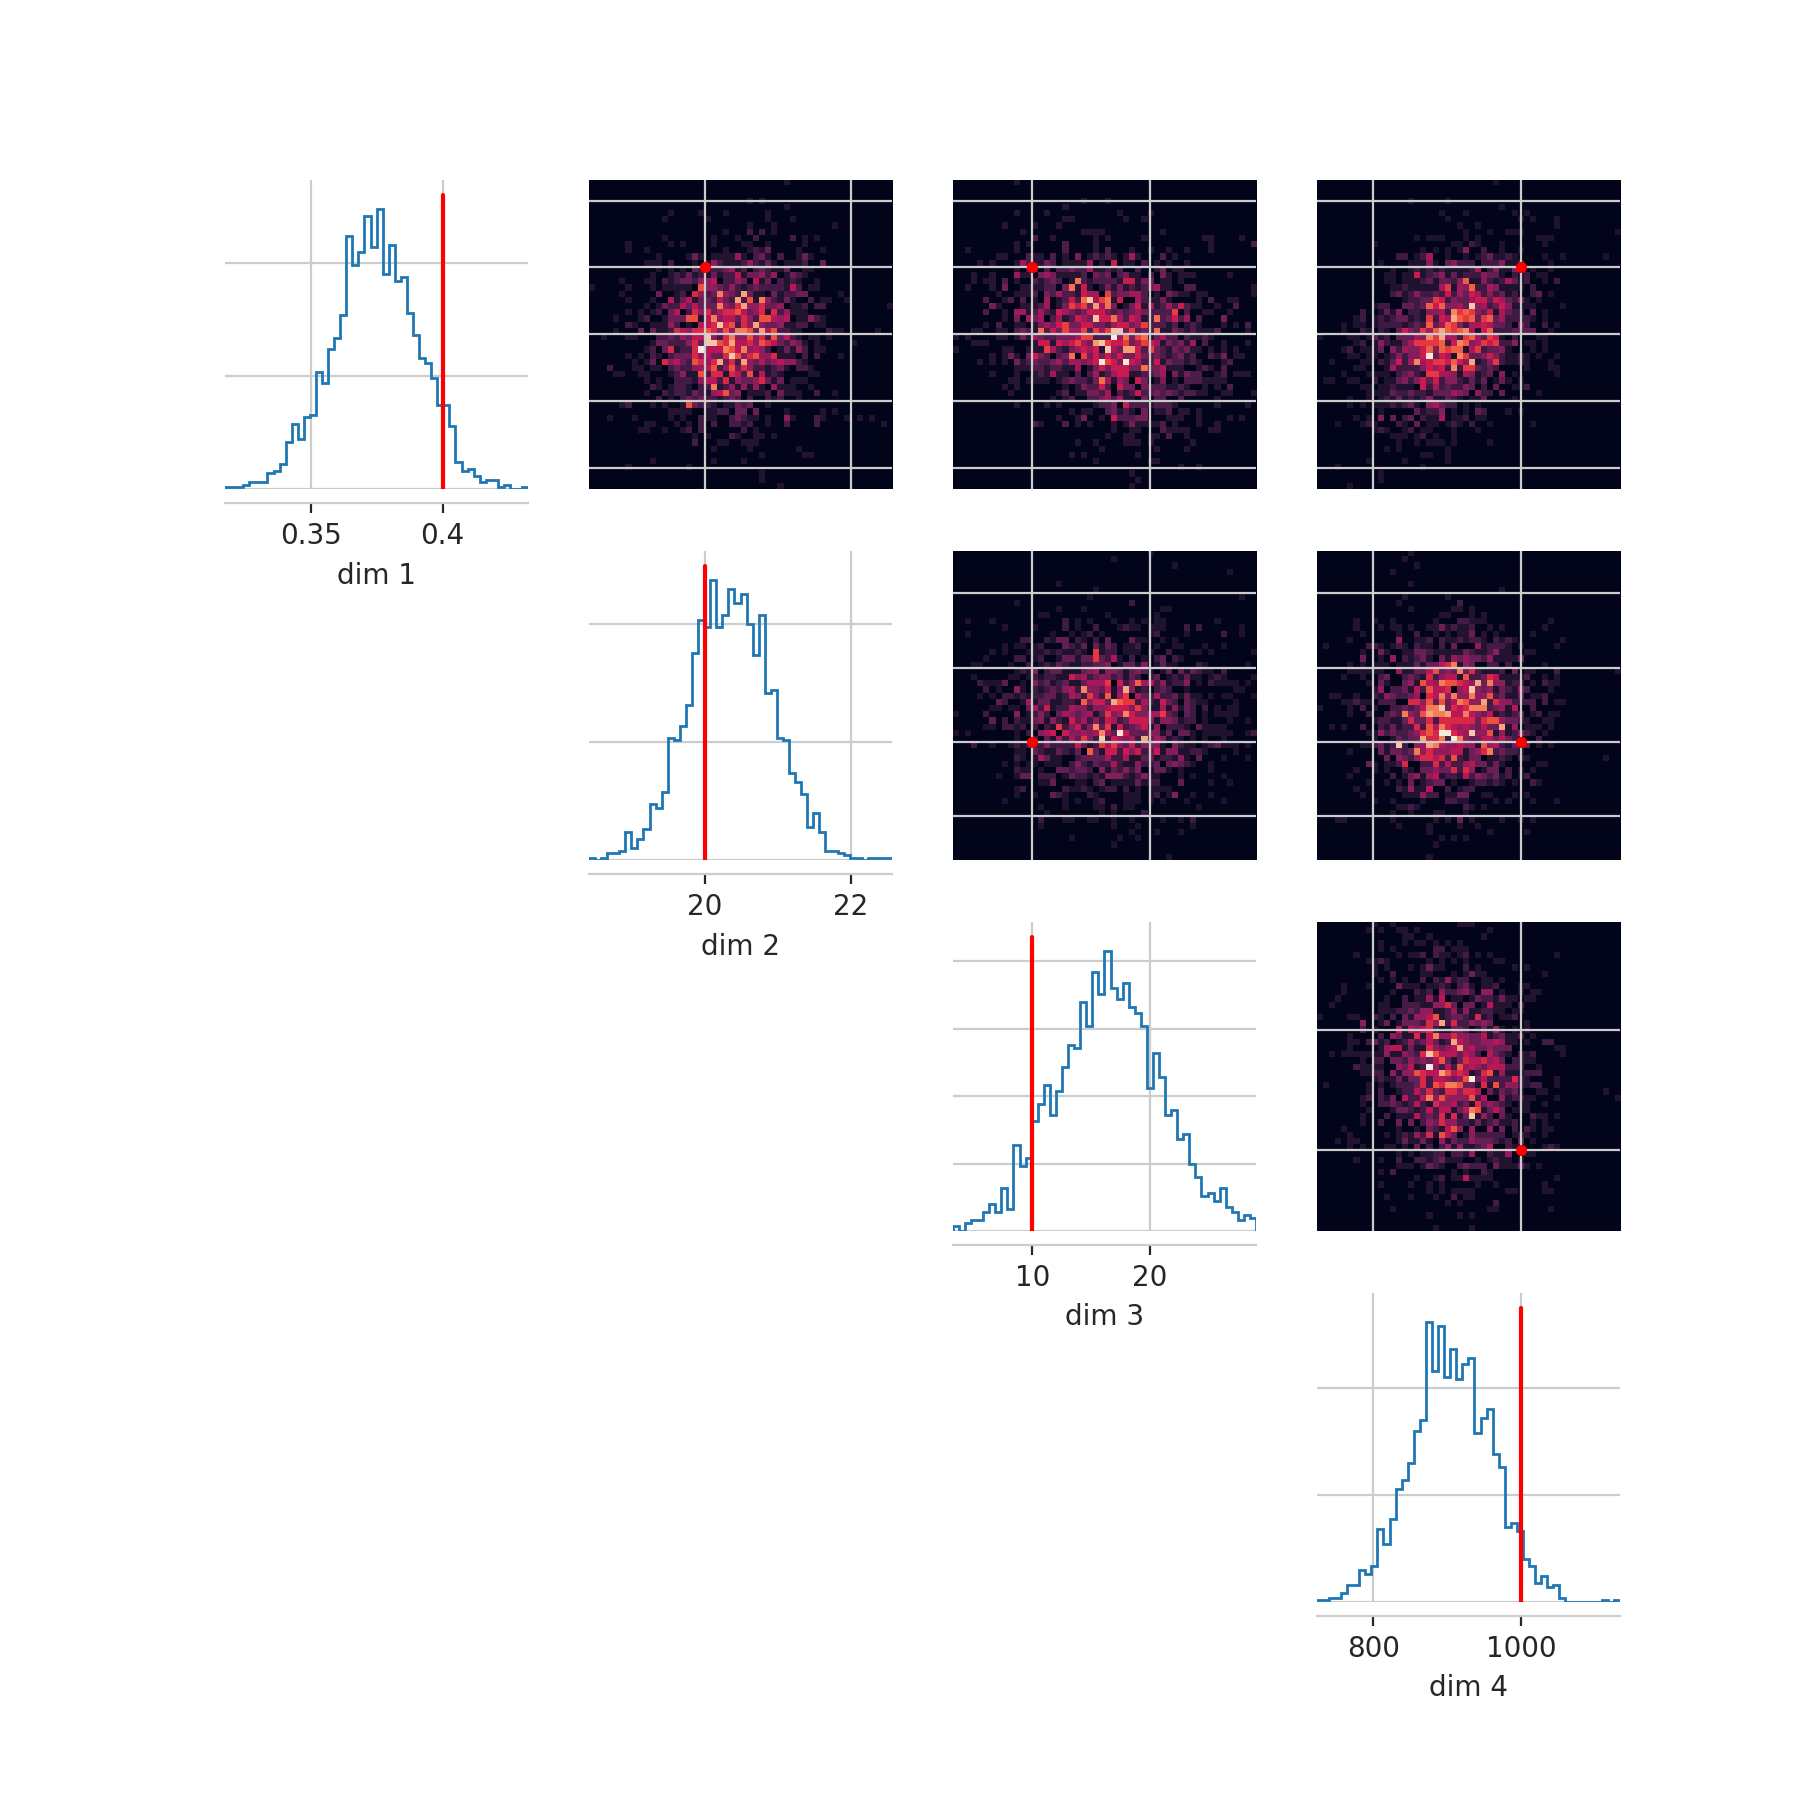

In [62]:
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors='r');


In [156]:
pal = sns.color_palette()

<IPython.core.display.Javascript object>


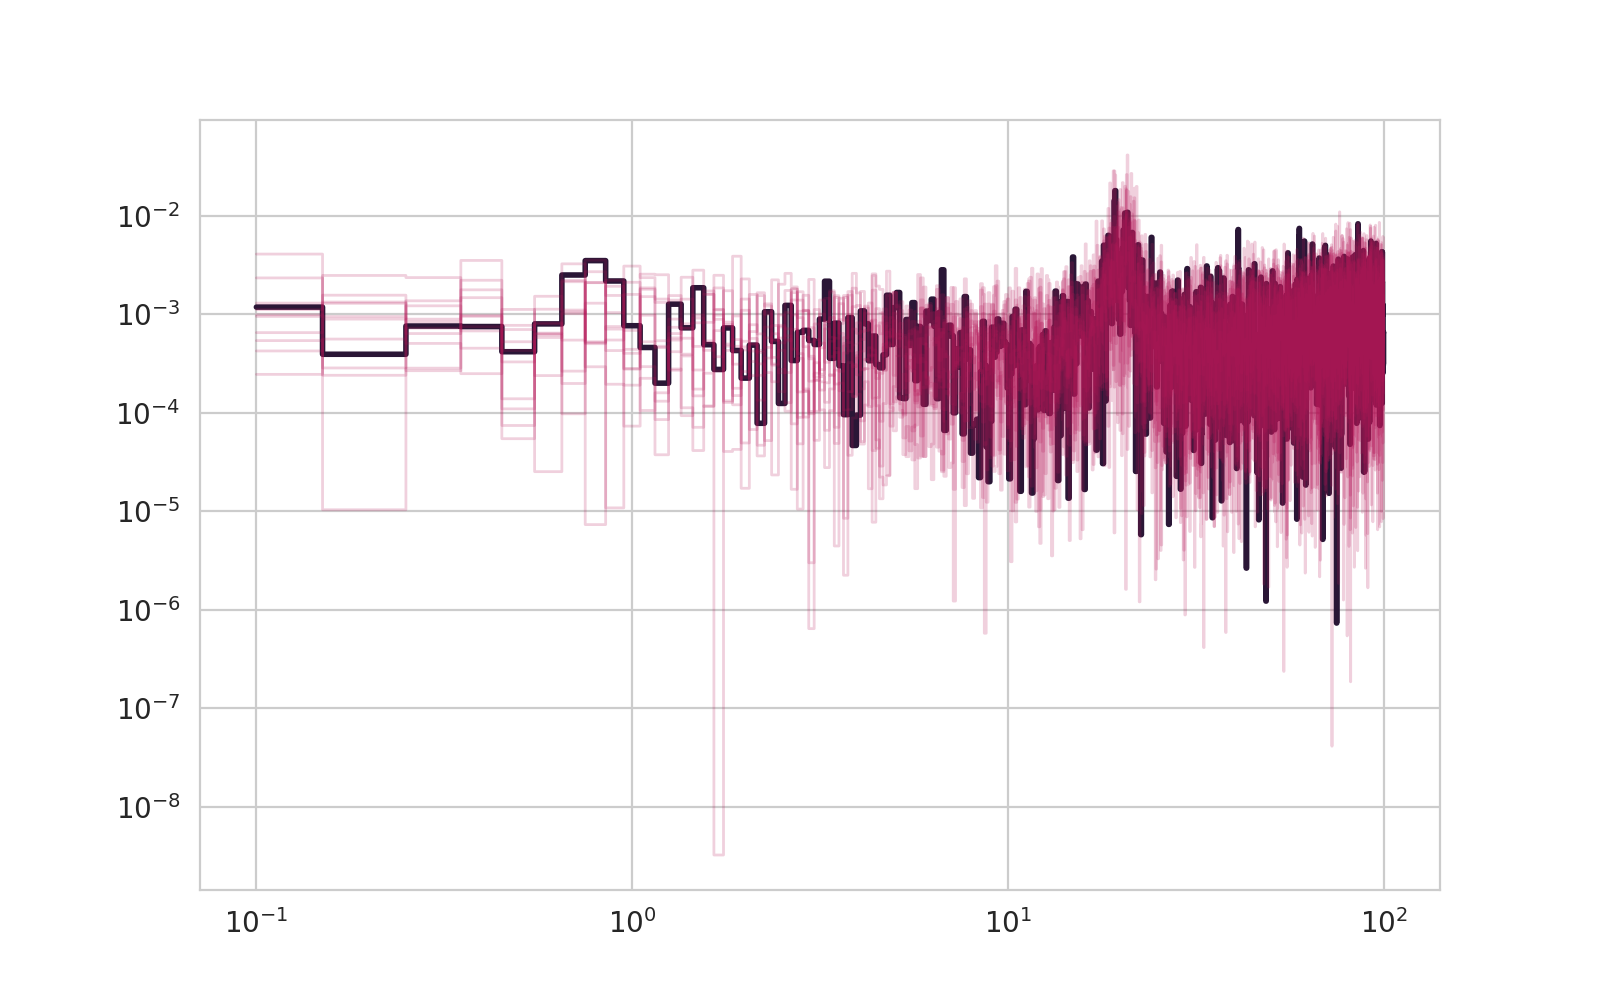

In [157]:
samples = posterior.sample((2000,), 
                           x=torch.as_tensor(ps_obs_dt.power))
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors='r');



samples = np.array(samples)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples[i,:]
    ps_sim = np.array(simulation(param_sim))
    
    ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    

This looks pretty good. Let's generate another data set and sample from the network for comparison:

In [64]:
# generate some ligth curves, both with (*_dt) and without dead time
lc1_test, lc2_test, lc1_test_dt, lc2_test_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)
lc_test_dt = lc1_test_dt + lc2_test_dt
ps_test_dt = Powerspectrum(lc_test_dt, norm="frac")
cs_test_dt = Crossspectrum(lc1_test_dt, lc2_test_dt, norm="frac")

In [148]:
samples_test = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_test_dt.power))

In [149]:
pal = sns.color_palette()

<IPython.core.display.Javascript object>


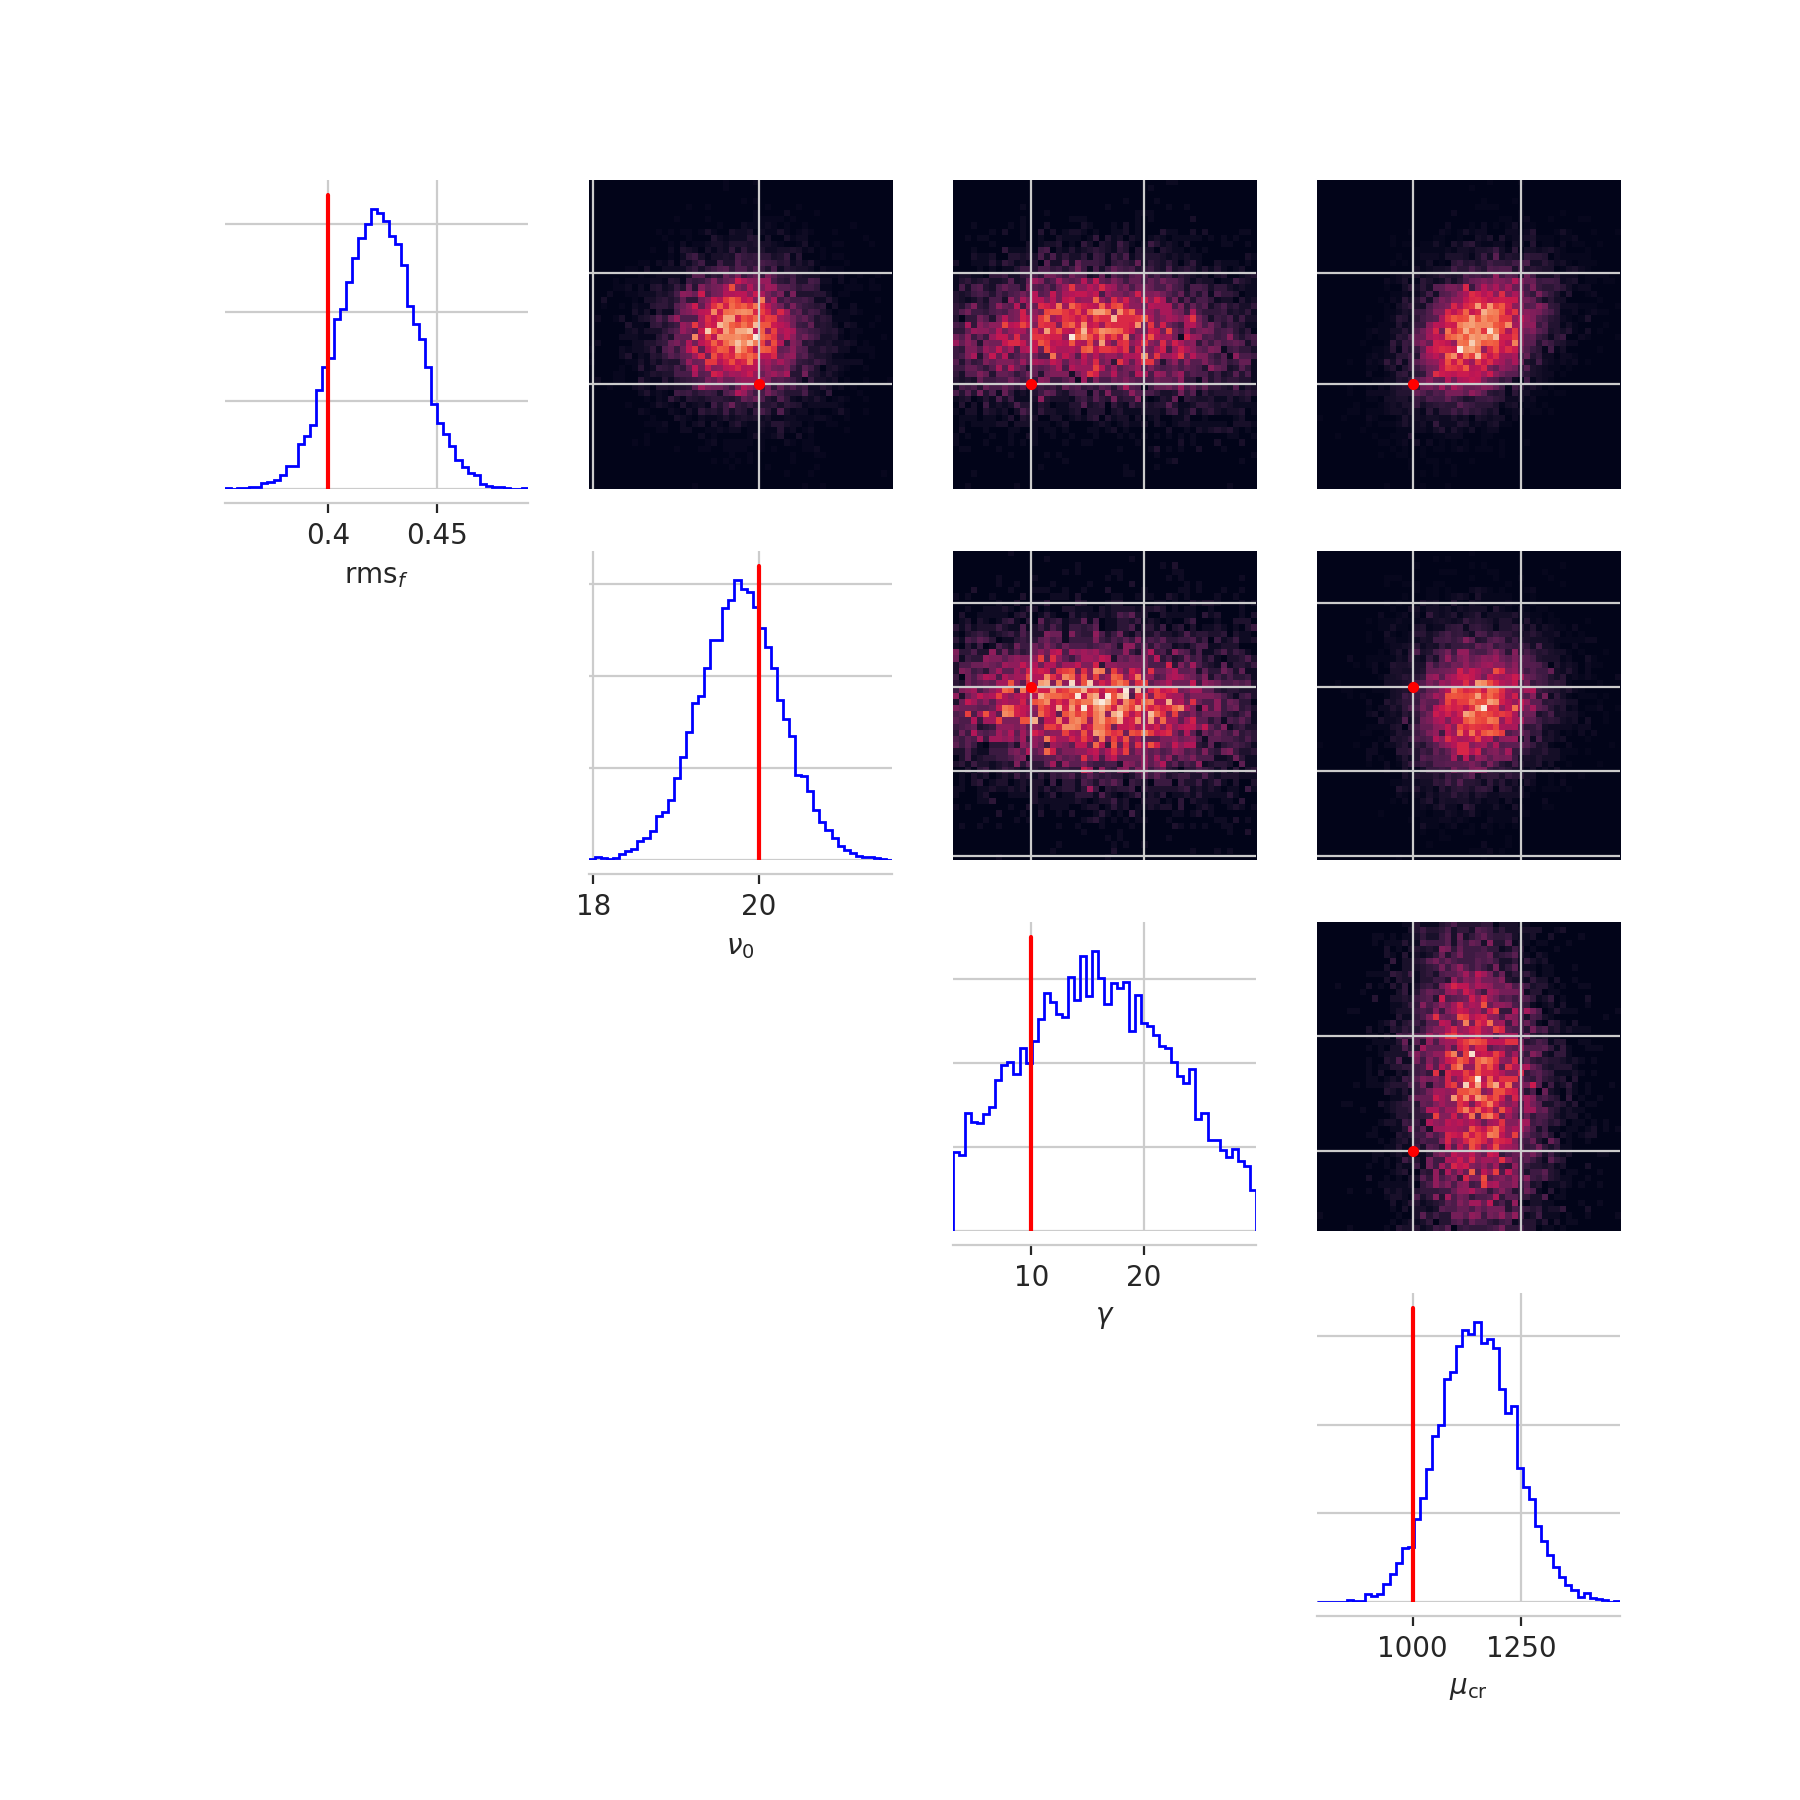

In [160]:
param_names = [r"$\mathrm{rms}_f$", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{cr}$"]
fig, axes =utils.pairplot(samples_test,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors="r",
                           labels=param_names,
                           samples_colors="black");



Let's also look at the posterior draws:

<IPython.core.display.Javascript object>


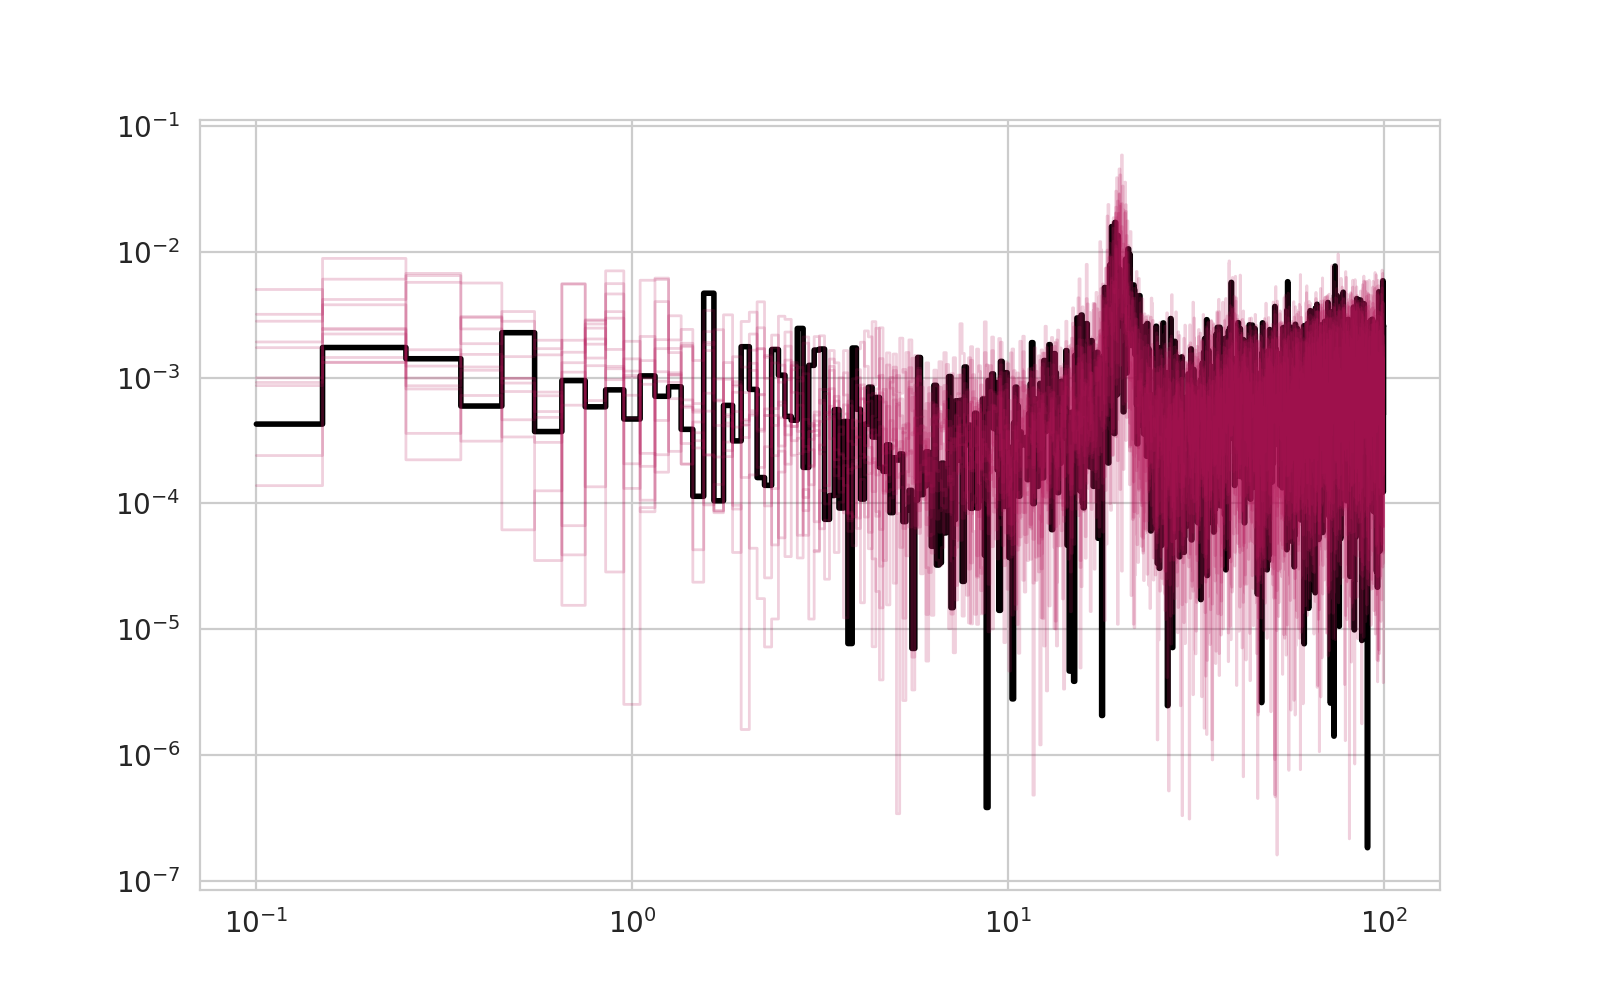

In [163]:
samples_test = np.array(samples_test)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_test_dt.freq, ps_test_dt.power, lw=2, 
          color="black", ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples_test.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples_test[i,:]
    ps_sim = np.array(simulation(param_sim))
    
    ax.loglog(ps_test_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    

For this, we can't do neither FAD (it's not an averaged periodogram), nor can we do MCMC (we don't have a likelihood for the cospectrum). But let's do MCMC on the periodogram without taking dead time into account, just for comparison:

In [68]:
from stingray.modeling import PSDPosterior, PSDParEst

In [69]:
qpo_model = models.Lorentz1D() + models.Const1D()

qpo_amp = 1.0
qpo_x0 = 20.0
qpo_fwhm = 2.0

qpo_model.amplitude = qpo_amp
qpo_model.x_0 = qpo_x0
qpo_model.fwhm = qpo_fwhm

amp_prior = scipy.stats.uniform(1e-10, 100).pdf
x0_prior = scipy.stats.uniform(5, 50).pdf
fwhm_prior = scipy.stats.uniform(0.01, 40).pdf

wn_prior = scipy.stats.uniform(1e-20, 1e5).pdf

priors = {"amplitude_0": amp_prior,
          "x_0_0": x0_prior,
          "fwhm_0": fwhm_prior,
          "amplitude_1": wn_prior}




In [80]:
lpost = PSDPosterior(ps_obs_dt.freq, ps_obs_dt.power, qpo_model, priors=priors)

parest = PSDParEst(ps_obs_dt, fitmethod="powell")

res = parest.fit(lpost, [0.01, 20, 5, 0.001])

print(res.p_opt)

[6.16870959e-03 1.99549167e+01 1.44585409e+00 9.23855416e-04]


<IPython.core.display.Javascript object>


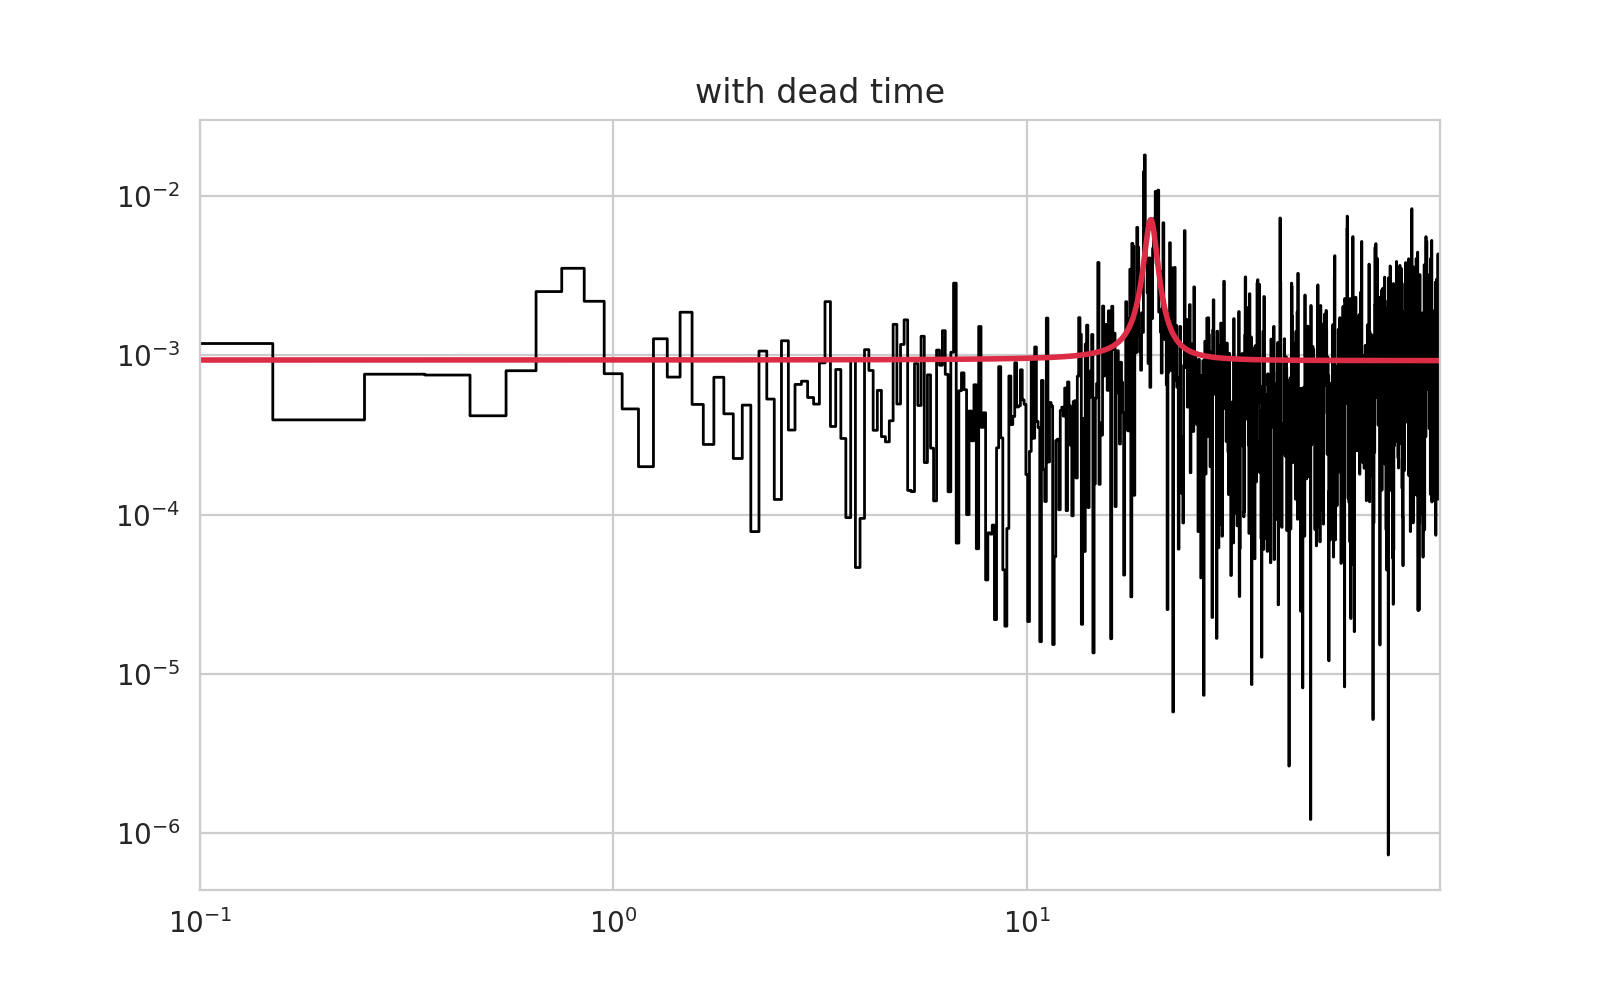

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=1, color="black", ds="steps-mid")
ax.set_xlim(ps_obs_dt.freq[0], ps_obs_dt.freq[-1])
ax.set_title("with dead time")

ax.loglog(ps_obs_dt.freq, res.mfit, lw=2, color=pal[4])


Let's do MCMC:

In [82]:
nwalkers = 20
burnin = 10
niter = 10000

samp_mcmc = parest.sample(lpost, res.p_opt, cov=res.cov, 
                             nwalkers=nwalkers, burnin=burnin, niter=niter)

-- The acceptance fraction is: 0.552815.5
INFO:MCMC summary:-- The acceptance fraction is: 0.552815.5
-- The autocorrelation time is: [97.40685826 55.93752169 83.59207862 53.10731339]
INFO:MCMC summary:-- The autocorrelation time is: [97.40685826 55.93752169 83.59207862 53.10731339]
R_hat for the parameters is: [1.79179212e-05 5.09050418e-02 1.58082953e-01 9.85509769e-10]
INFO:MCMC summary:R_hat for the parameters is: [1.79179212e-05 5.09050418e-02 1.58082953e-01 9.85509769e-10]
-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO:MCMC summary:---------------------------------------------

theta[0] 	 0.007768747551200344	0.004231723995178037	0.0037019496007208	0.014827730468709693

INFO:MCMC summary:theta[0] 	 0.007768747551200344	0.004231723995178037	0.0037019496007208	0.014827730468709693

theta[1] 	

Let's plot some draws from the posterior:

In [83]:
samp_mcmc.samples

array([[3.95035476e-03, 2.02645483e+01, 1.64013532e+00, 9.66652497e-04],
       [6.88665082e-03, 2.00132666e+01, 1.21685958e+00, 8.95446825e-04],
       [4.68161705e-03, 2.01378292e+01, 1.75931349e+00, 9.01402819e-04],
       ...,
       [5.59700049e-03, 2.01874147e+01, 1.65195544e+00, 9.16779339e-04],
       [7.23252068e-03, 1.98816709e+01, 1.64870715e+00, 9.12344603e-04],
       [7.23659463e-03, 1.99535872e+01, 1.60570642e+00, 9.14318163e-04]])

<IPython.core.display.Javascript object>


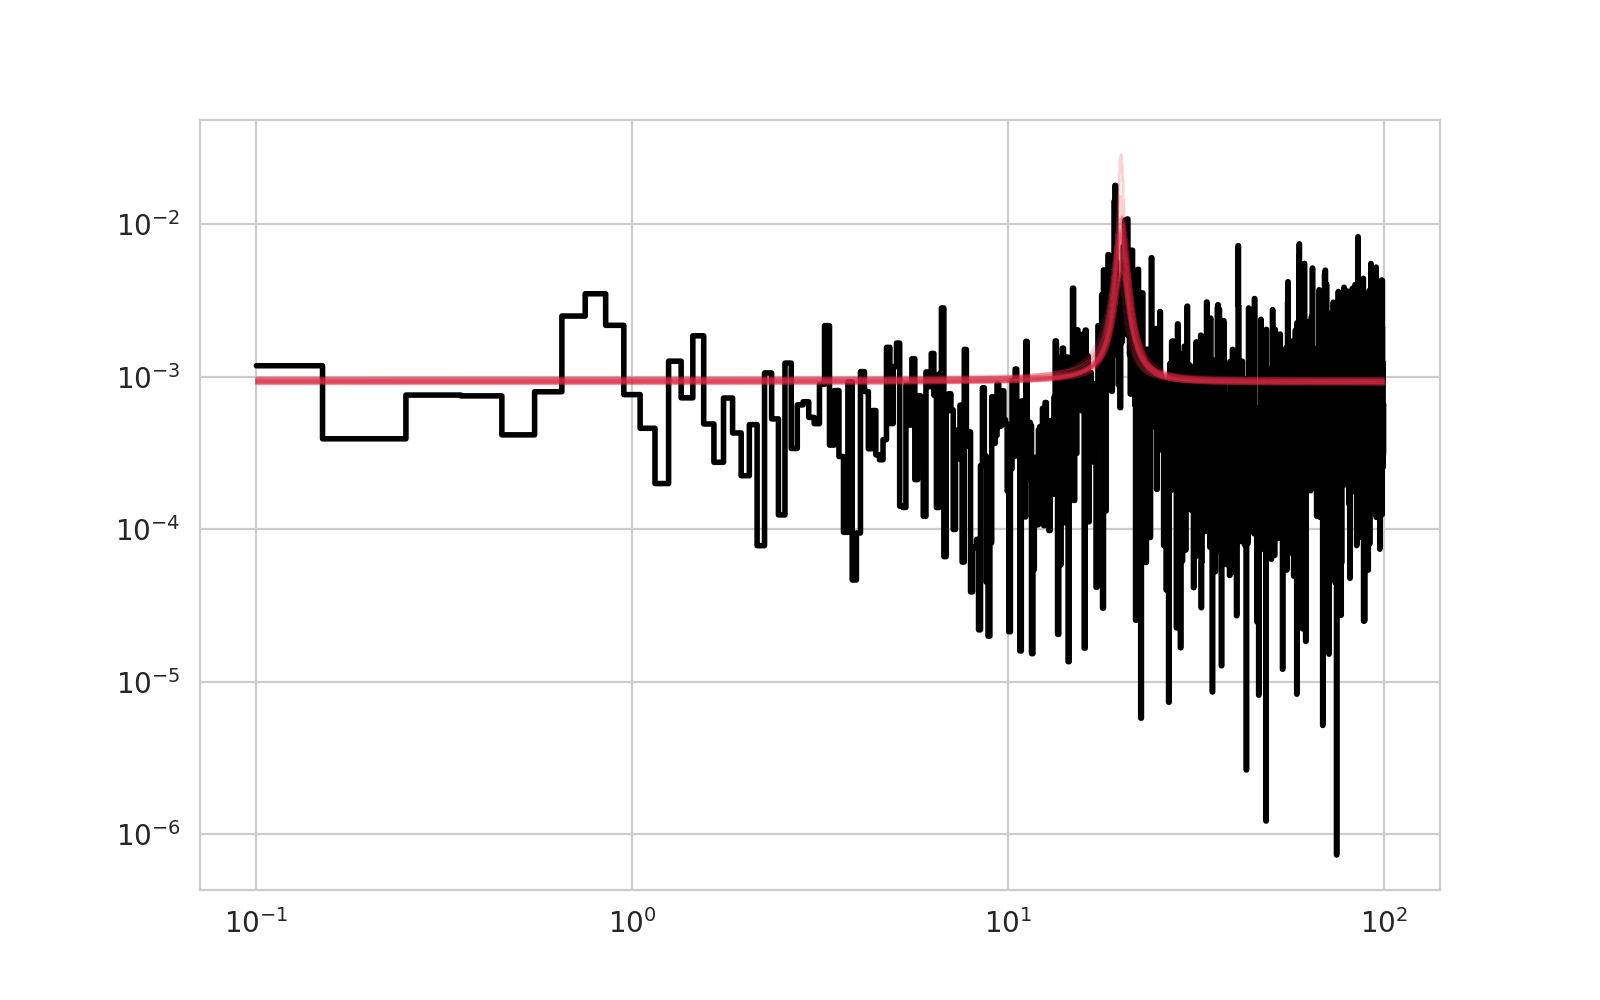

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color="black", ds="steps-mid");

# plot simulations

nsim = 20
idx = np.random.choice(np.arange(0, samp_mcmc.samples.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samp_mcmc.samples[i,:]
    #print(param_sim)
    ps_sim = lorentzian(ps_obs_dt.freq, *param_sim[:-1]) + param_sim[-1]
    
    ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[4], alpha=0.2, ds='steps-mid')
    

Okay, let's also make a corner plot:

<IPython.core.display.Javascript object>


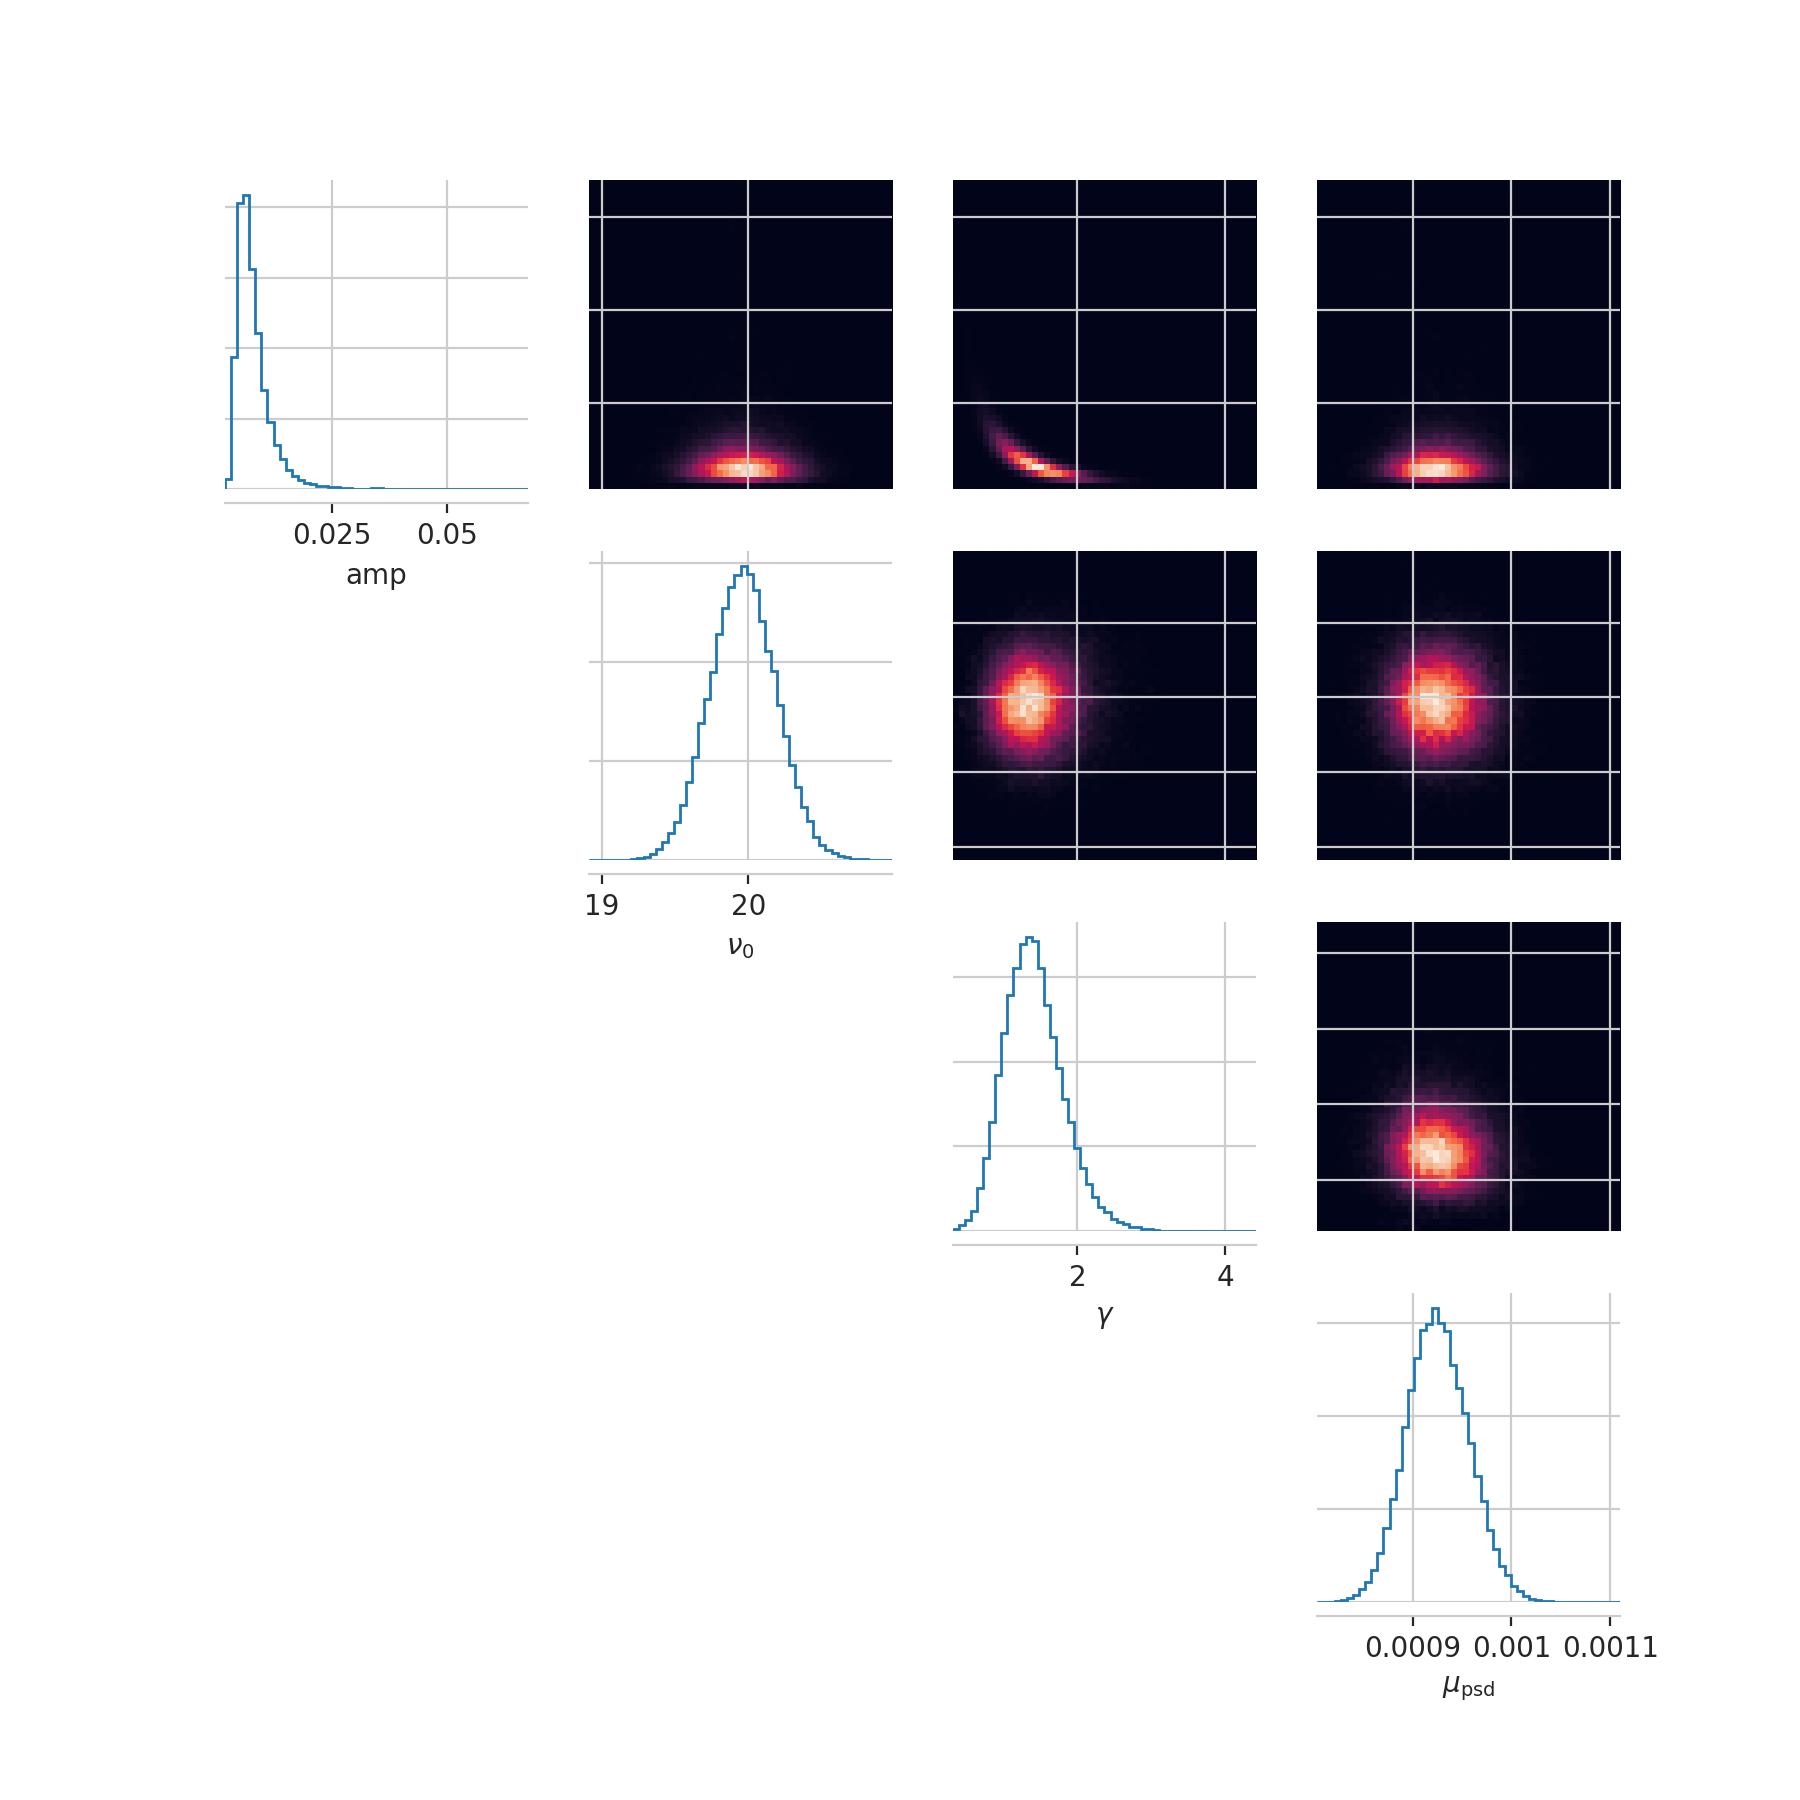

In [88]:
labels = ["amp", r"$\nu_0$", r"$\gamma$", r"$\mu_\mathrm{psd}$"]

fig, axes = utils.pairplot(samp_mcmc.samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           labels=labels)
                           #points=np.array(param_obs),
                           #points_offdiag={'markersize': 6},
                           #points_colors='r');




In [173]:
rms_dt = np.array([np.sqrt(np.sum(lorentzian(ps_obs_dt.freq, *s[:-1])*ps_obs_dt.df)) for s in samp_mcmc.samples[-5000:,:]])

<IPython.core.display.Javascript object>


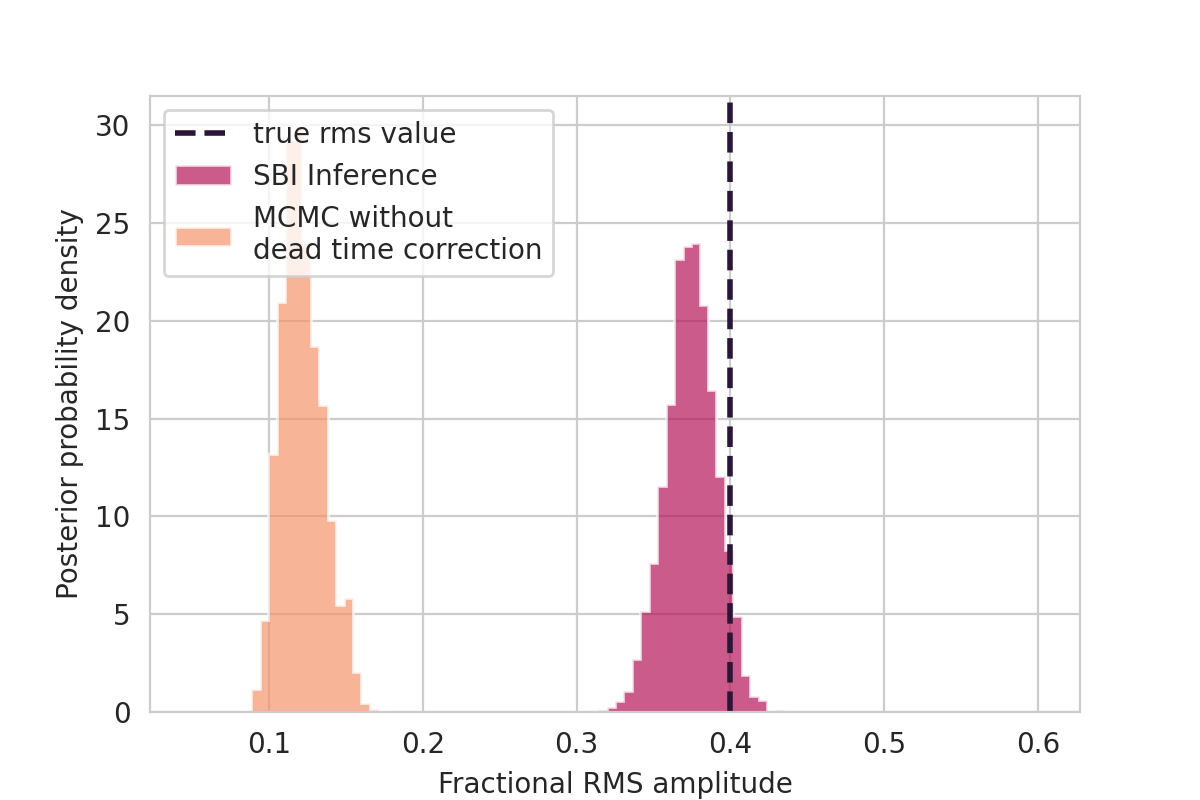

Text(0, 0.5, 'Posterior probability density')

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

xrange = [0.05, 0.6]

ax.hist(samples[:,0], bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="SBI Inference", color=pal[3])
ax.hist(rms_dt, bins=100, histtype="stepfilled", alpha=0.7, 
        range=xrange, density=True, label="MCMC without \ndead time correction",
        color=pal[6])

ax.axvline(param_obs[0], lw=2, c=pal[0], ls="dashed", label="true rms value")

ax.legend(loc="upper left")

ax.set_xlabel("Fractional RMS amplitude")
ax.set_ylabel("Posterior probability density")

I think this is a plot I want to have in the paper!

## High-Frequency QPO

At higher frequencies, dead time often has a worse effect, so let's redo the same analysis but for a high-frequency QPO:

In [209]:
np.random.seed(20201207)

qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 200.0 # centroid frequency of the QPO, in Hz
qpo_qual = 15.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.45 # fractional RMS amplitude of the QPO

tseg = 10.0 # total duration in seconds
dt_nustar = 1e-5 # time resolution of NuSTAR
dt = 0.0005 # time step of the output light curve
npoints = int(np.round(tseg/dt_nustar)) # total number of points in original light curve

mean_countrate_obs = 1000
mean_counts_nustar_obs = mean_countrate_obs * dt_nustar

df_nustar = 1.0/tseg # frequency resolution of the PSD/CSD
fmax_nustar = 0.5/dt_nustar # maximum frequency in the CSD/PSD

# dead time for nustar
deadtime_nustar = 0.0025

# list of frequencies
freq = np.linspace(df_nustar, fmax_nustar, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

# store parameters in a list for easy (plotting) access
param_obs = [rms_obs, qpo_x0, qpo_qual, mean_countrate_obs]

# generate some ligth curves, both with (*_dt) and without dead time
lc1_obs, lc2_obs, lc1_obs_dt, lc2_obs_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)

In [210]:
lc_obs = lc1_obs + lc2_obs
lc_obs_dt = lc1_obs_dt + lc2_obs_dt

ps_obs = Powerspectrum(lc_obs, norm="frac")
ps_obs_dt = Powerspectrum(lc_obs_dt, norm="frac")

cs_obs = Crossspectrum(lc1_obs, lc2_obs, norm="frac")
cs_obs_dt = Crossspectrum(lc1_obs_dt, lc2_obs_dt, norm="frac")

<IPython.core.display.Javascript object>


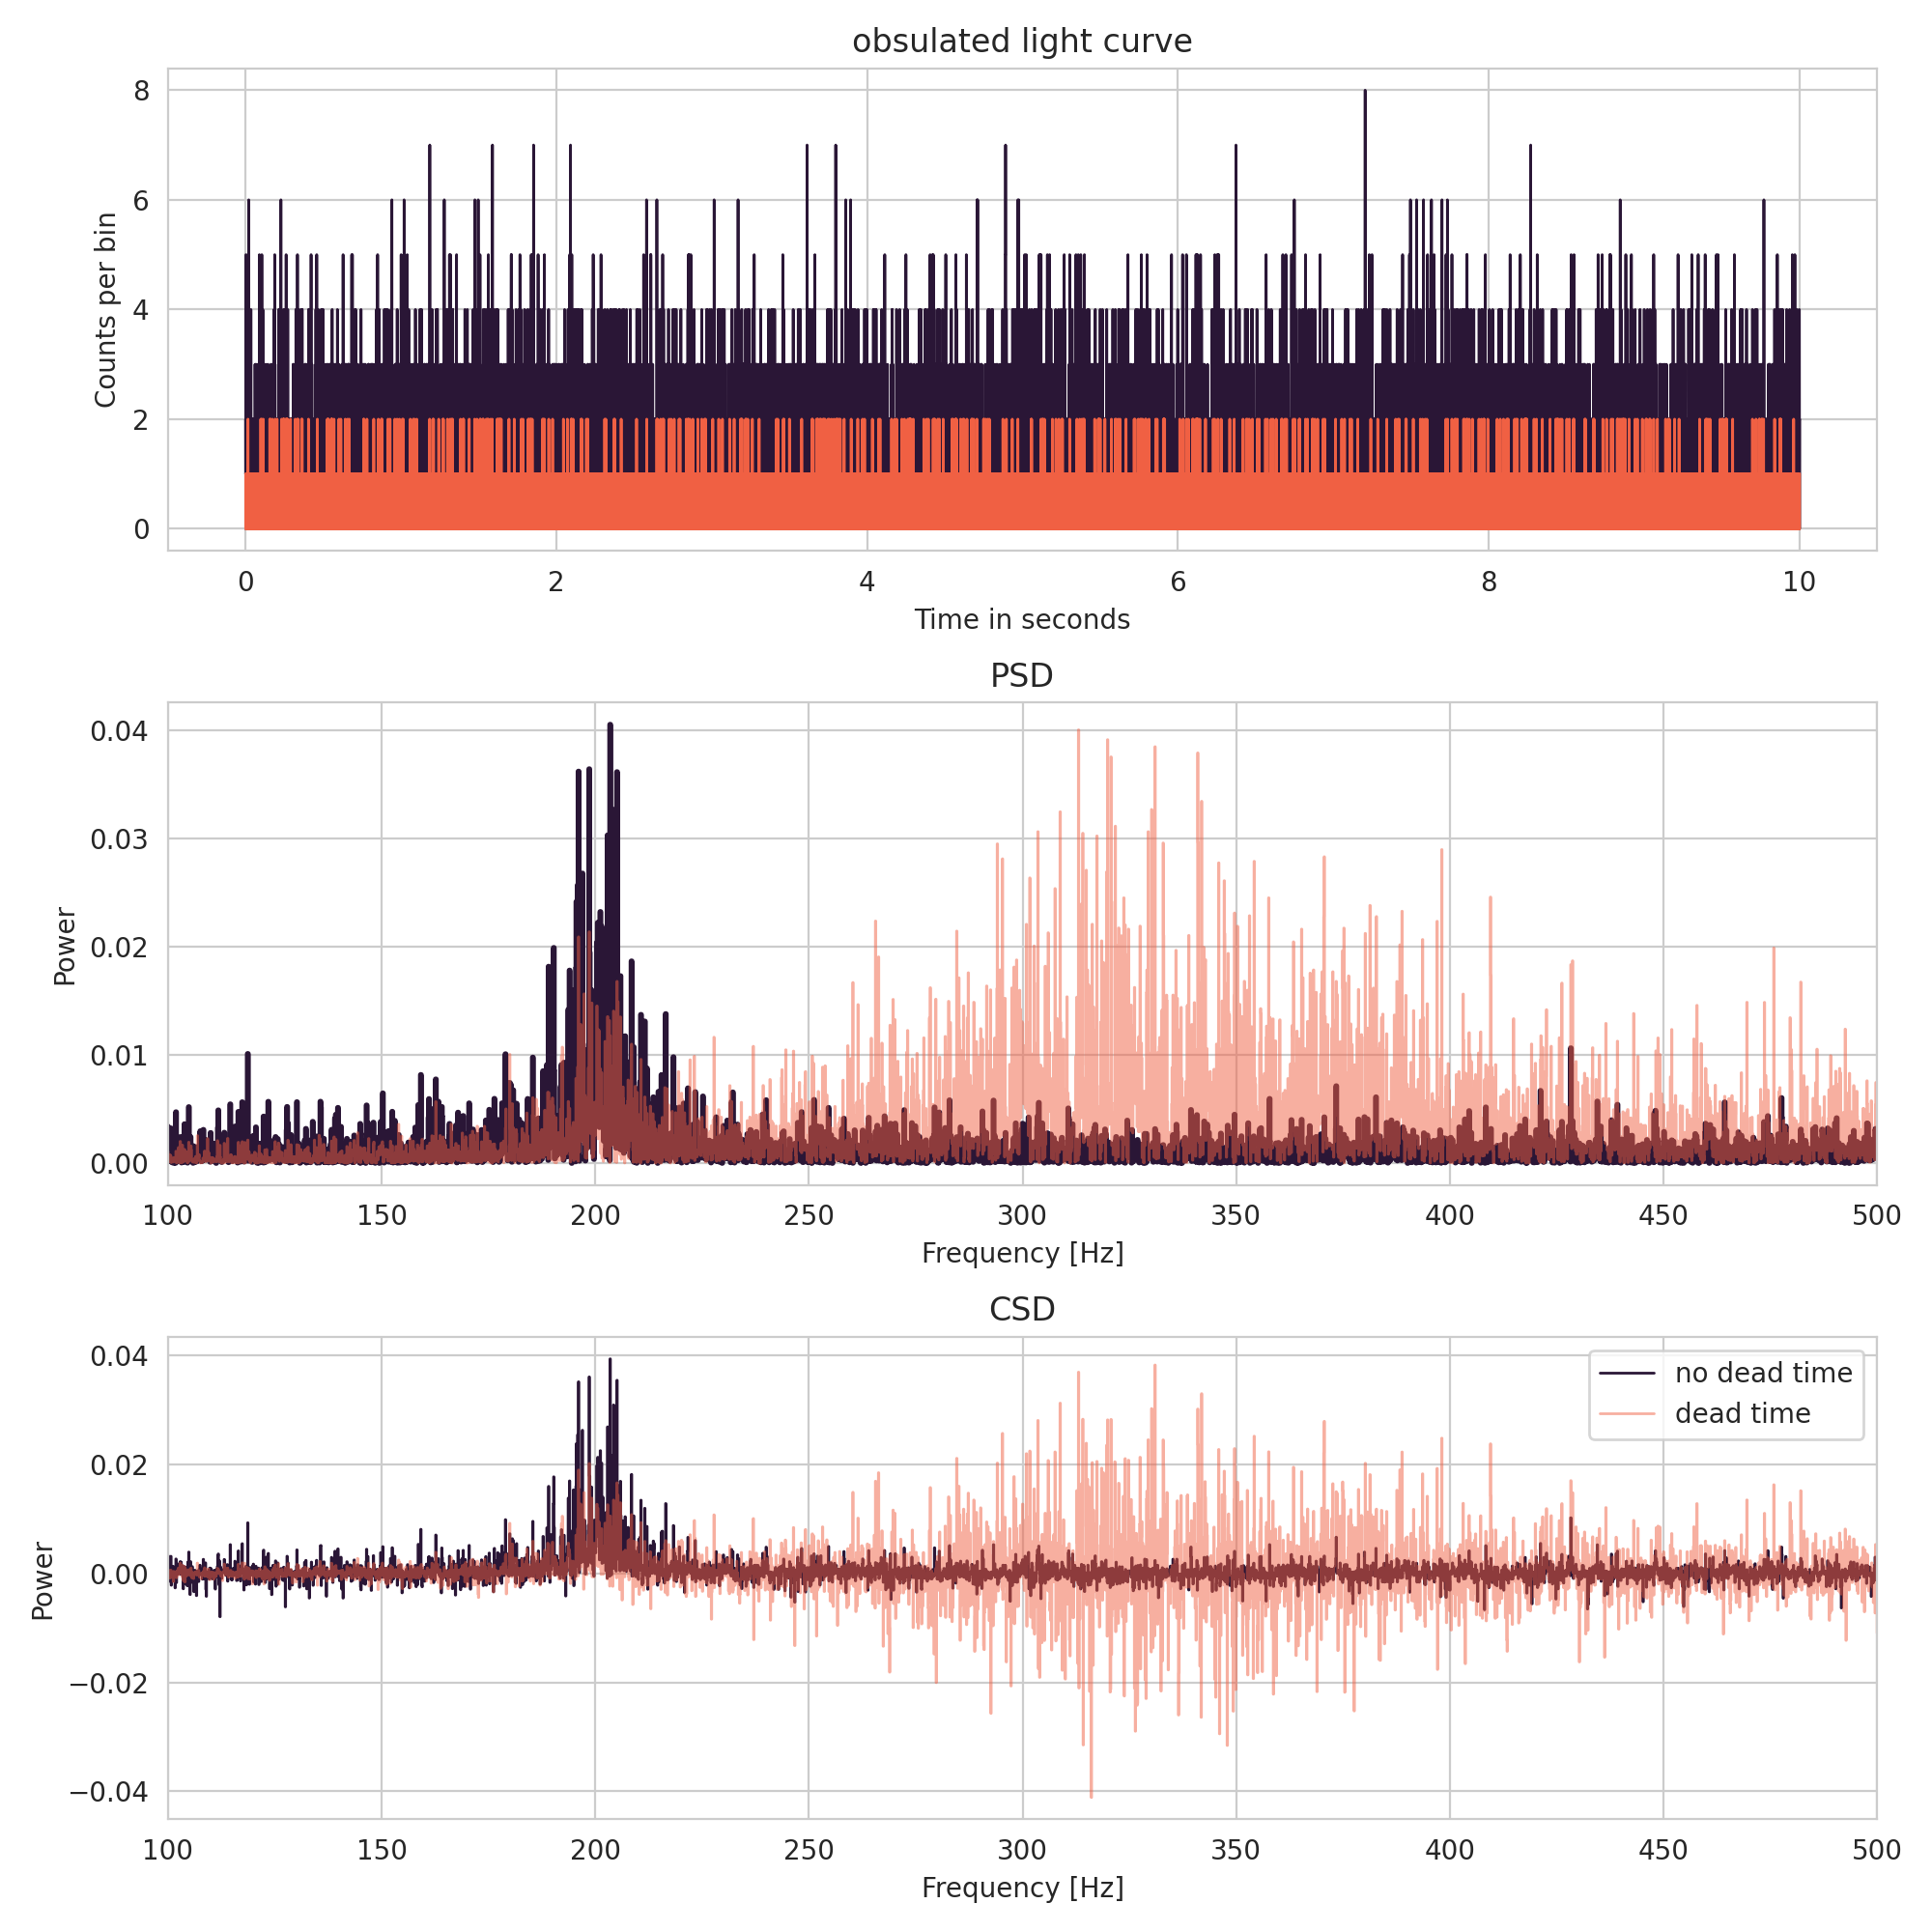

In [211]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]

ax1.plot(lc_obs.time, lc_obs.counts, ds="steps-mid", lw=1, label="no dead time", c=c1)
ax1.plot(lc_obs_dt.time, lc_obs_dt.counts, ds="steps-mid", lw=1, label="dead time", c=c2)
ax1.set_xlabel("Time in seconds")
ax1.set_ylabel("Counts per bin")
ax1.set_title("obsulated light curve")

ax2.plot(ps_obs.freq, ps_obs.power, lw=2, ds="steps-mid", label="no dead time", c=c1)
ax2.plot(ps_obs_dt.freq, ps_obs_dt.power, lw=1, ds="steps-mid", 
             label="dead time", c=c2, alpha=0.5)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power")
ax2.set_title("PSD")
ax2.set_xlim([100,500])

ax3.plot(cs_obs.freq, cs_obs.power, lw=1, ds="steps-mid", label="no dead time", c=c1)
ax3.plot(cs_obs_dt.freq, cs_obs_dt.power, lw=1, ds="steps-mid", 
             label="dead time", c=c2, alpha=0.5)
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Power")
ax3.set_title("CSD")
ax3.set_xlim([100,500])


ax3.legend()

plt.tight_layout()

Now we can set up our simulation-based inference. First, we need a function that takes a set of parameters as input, and then returns some form of data we want to compare, in our case the periodogram powers directly:

Next, we need to set up priors. We're going to make some assumptions about what values are reasonable:

In [212]:
lower_bounds = torch.tensor([0.1, 100.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 500.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )

Okay, let's see if we can actually run the neural network emulation. Here's a dictionary with the keyword argument for the simulator:

In [213]:
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.0005, "deadtime":0.0025, "summary_type":"psd"}

Now we can generate a simulator function to use in the SBI interface:

In [214]:
simulator = generate_simulator_function(**simulation_kwargs)

Let's give it a try, just to be sure:

In [215]:
test_data = simulator(param_obs)

In [216]:
test_data[:10]

tensor([0.0003, 0.0012, 0.0001, 0.0021, 0.0006, 0.0007, 0.0009, 0.0011, 0.0003,
        0.0002], dtype=torch.float64)


Neural network successfully converged after 22 epochs.


<IPython.core.display.Javascript object>


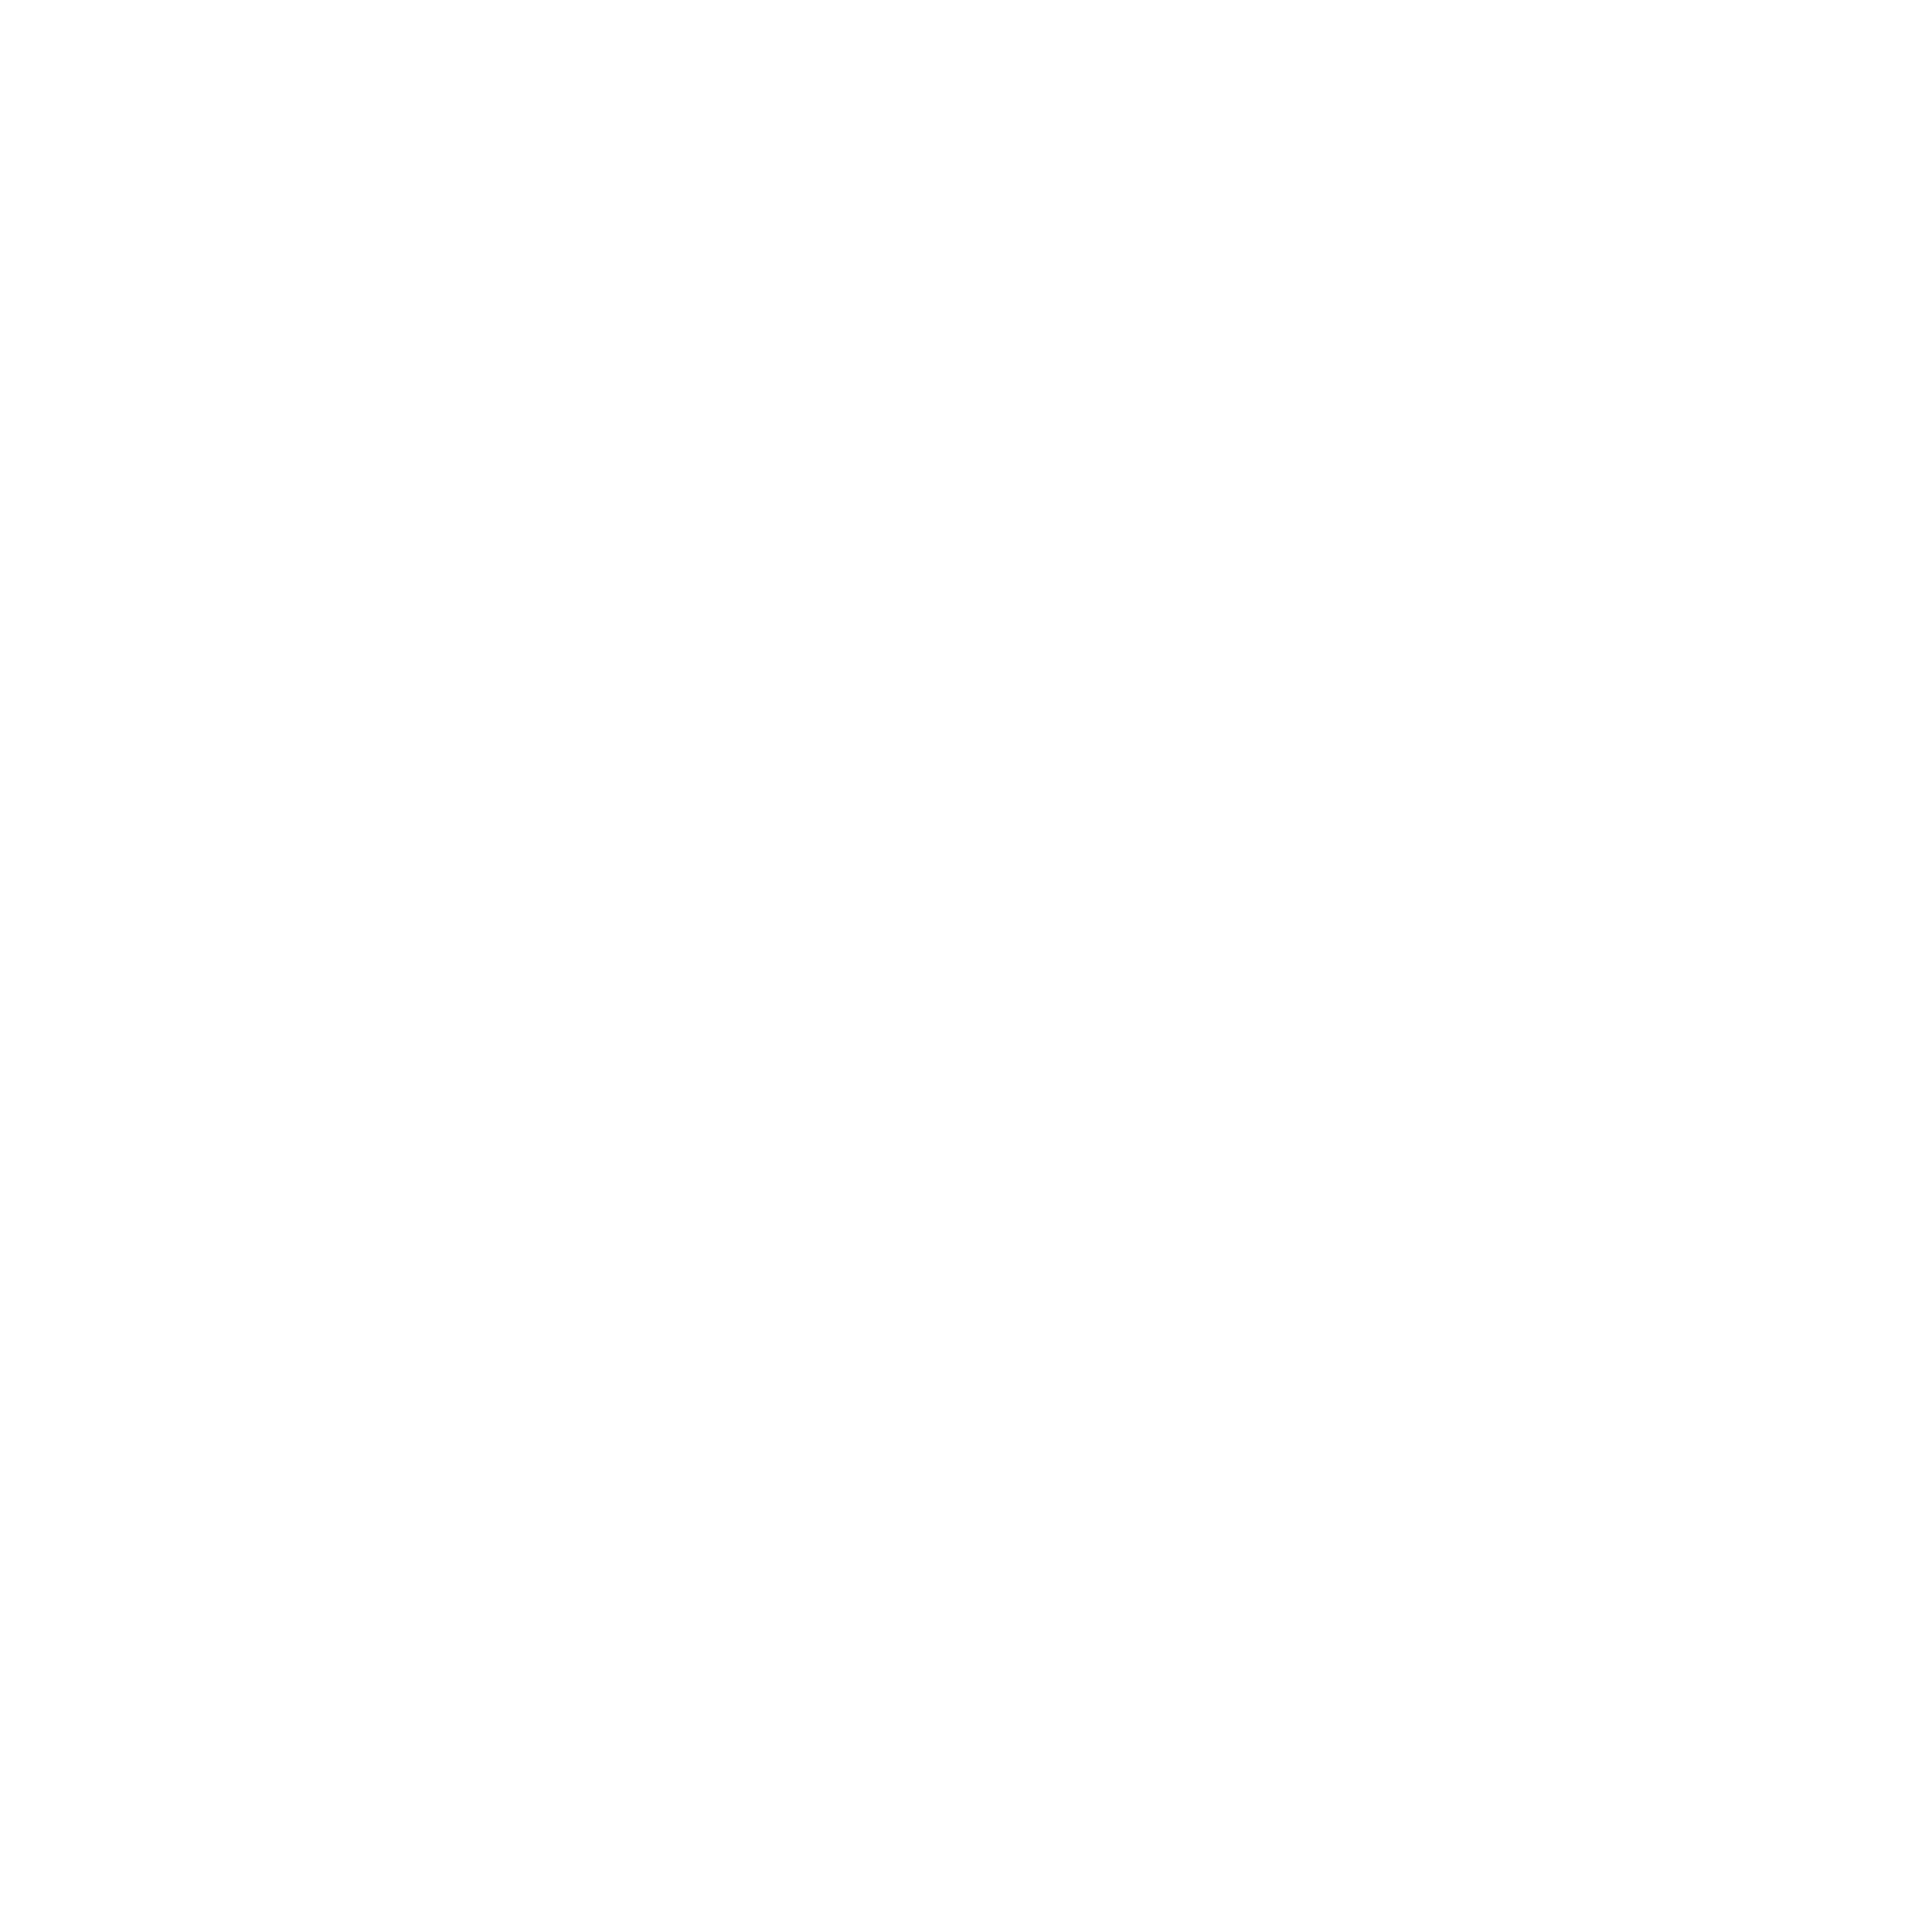

In [228]:
num_sim = 30000
method = "SNPE"

posterior = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

In [229]:
samples = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_obs_dt.power))

<IPython.core.display.Javascript object>


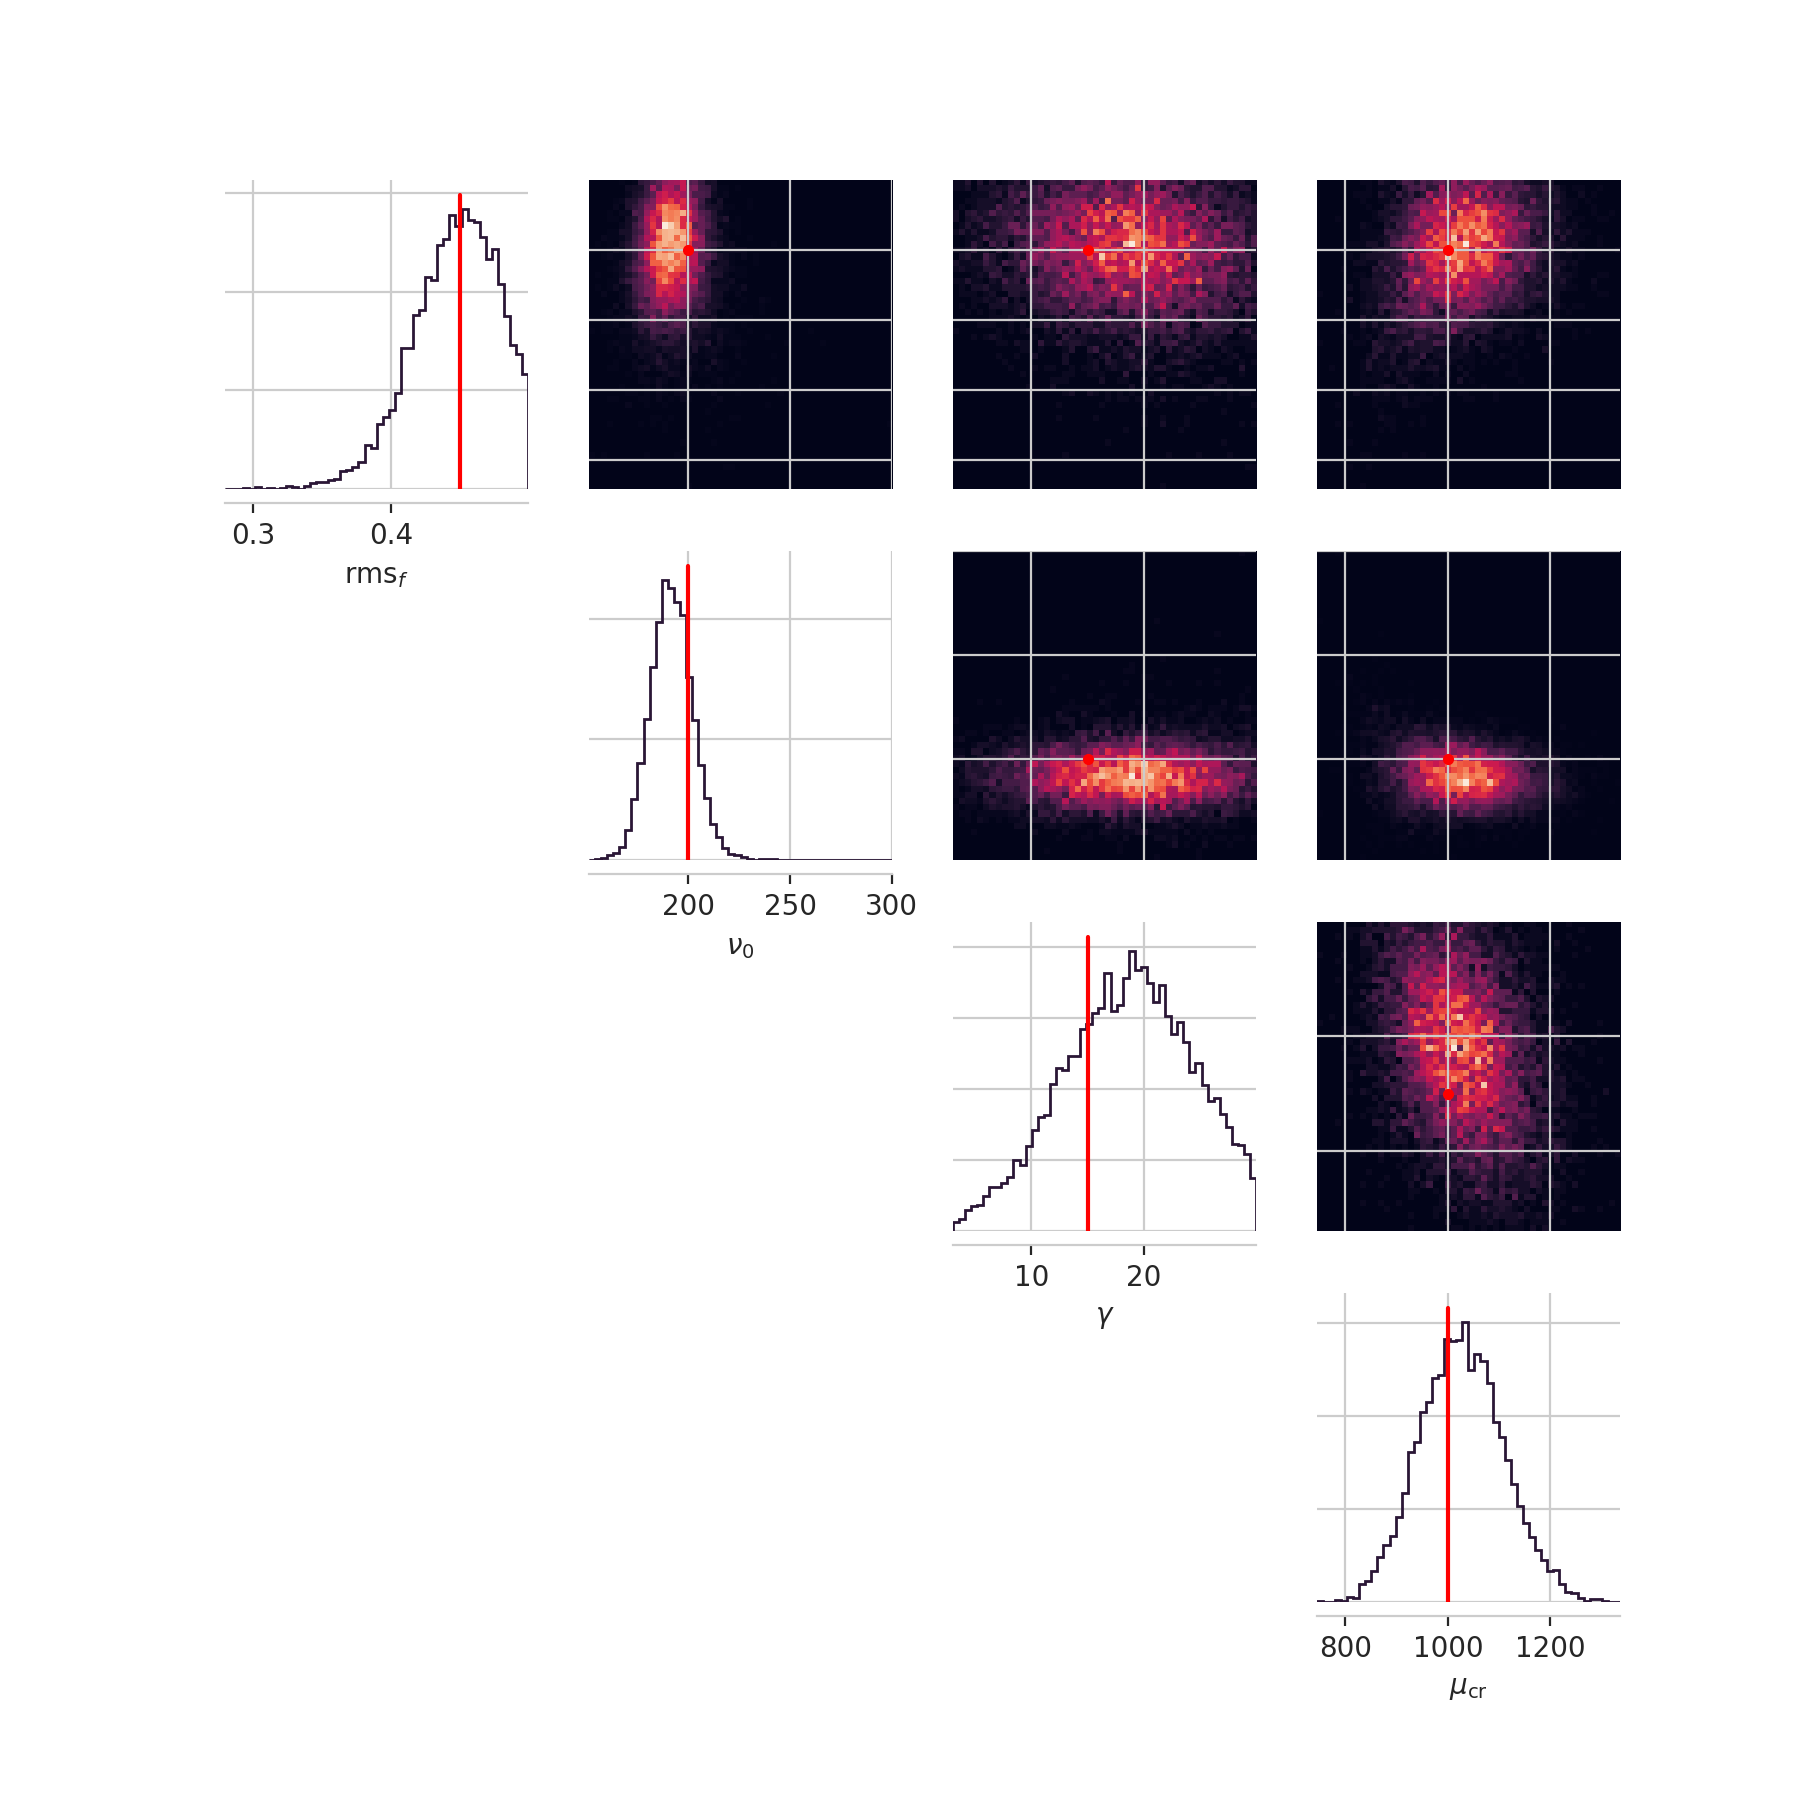

In [230]:
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           labels=param_names,
                           points_colors='r');


In [231]:
pal = sns.color_palette()

<IPython.core.display.Javascript object>


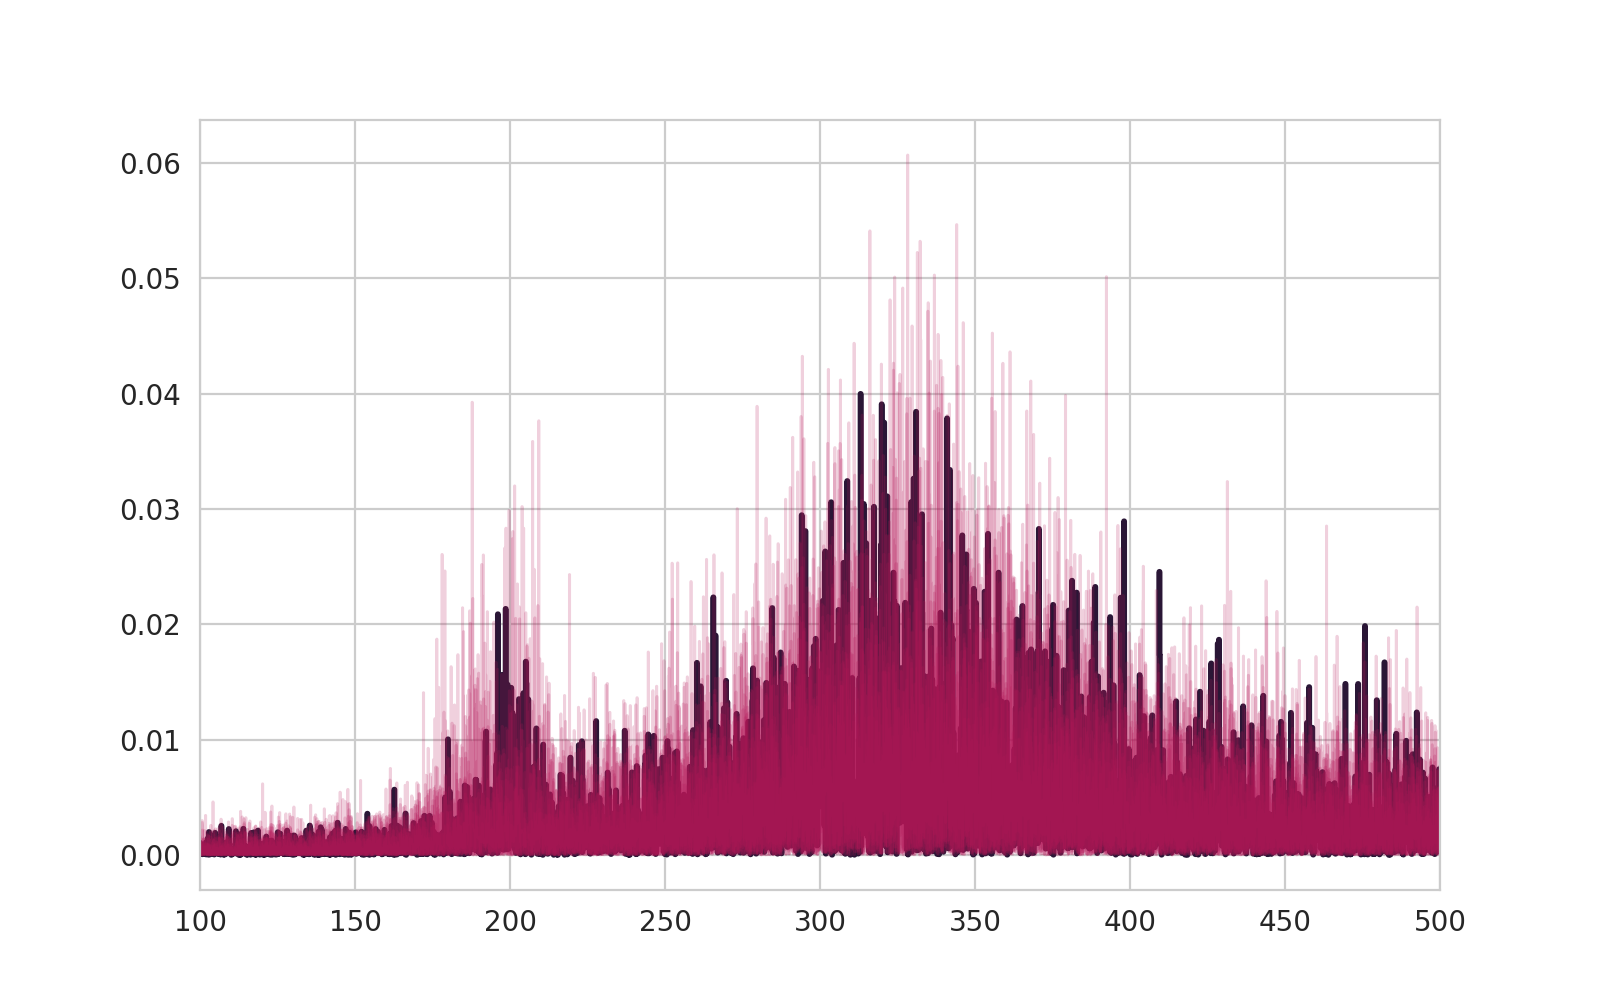

(100.0, 500.0)

In [233]:
samples = np.array(samples)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples[i,:]
    ps_sim = np.array(simulator(param_sim))
    
    ax.plot(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    
ax.set_xlim(100, 500)

### Log-Binned Periodogram

Because there are more bins to search at high frequencies, let's log-bin the periodogram to see what that does:

In [242]:
f = 0.01
ps_log_dt = ps_obs_dt.rebin_log(f)
ps_log = ps_obs.rebin_log(f)

<IPython.core.display.Javascript object>


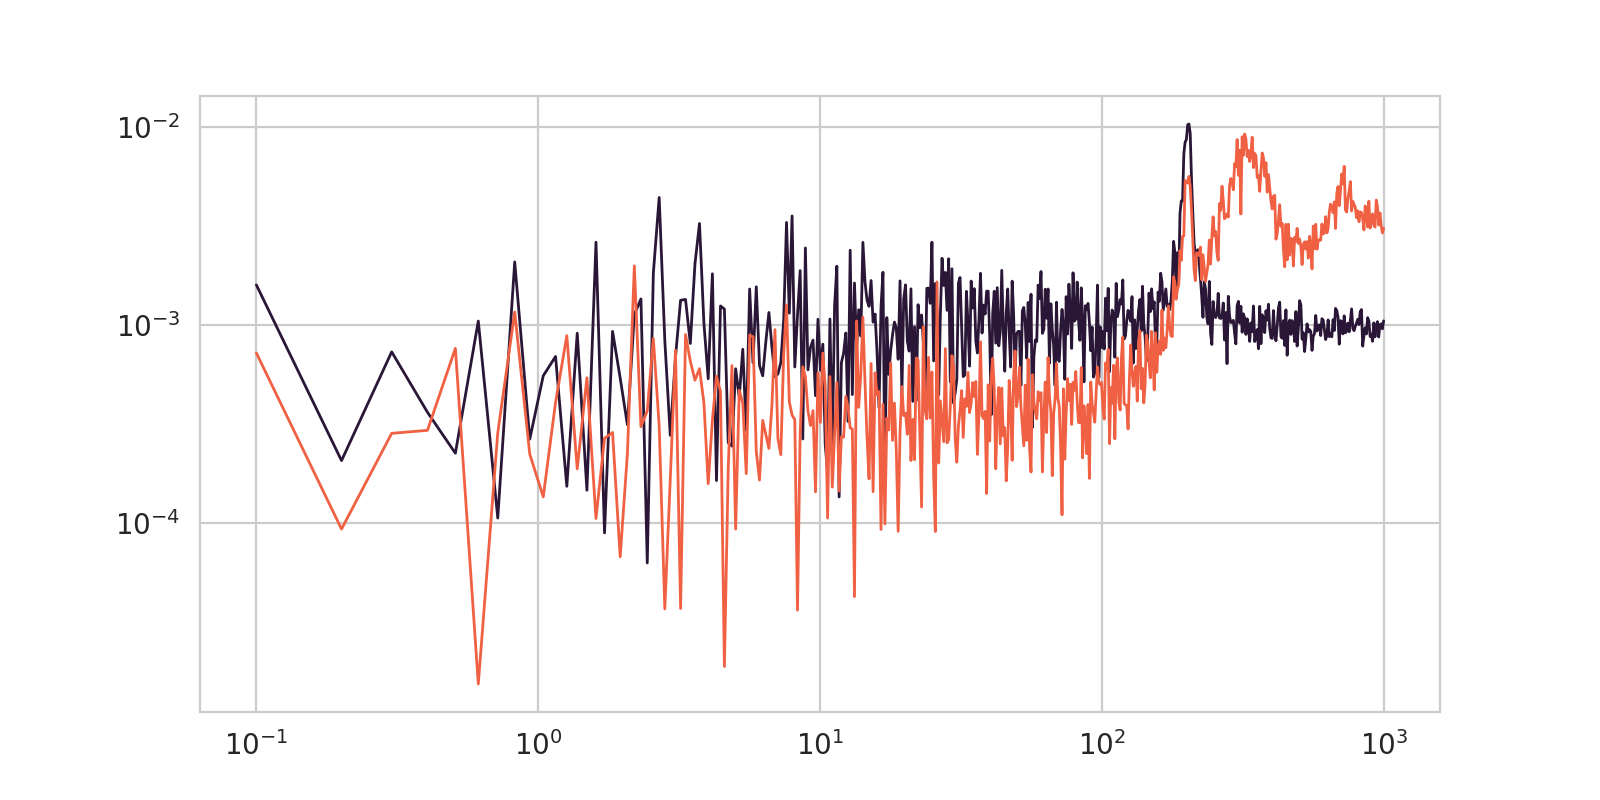

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]


ax.loglog(ps_log.freq, ps_log.power, lw=1, c=c1, label='without dead time')
ax.loglog(ps_log_dt.freq, ps_log_dt.power, lw=1, c=c2, label="with dead time")

In [244]:
lower_bounds = torch.tensor([0.1, 100.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 500.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )

Okay, let's see if we can actually run the neural network emulation. Here's a dictionary with the keyword argument for the simulator:

In [245]:
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.0005, "deadtime":0.0025, "summary_type":"logbin", "f":f}

Now we can generate a simulator function to use in the SBI interface:

In [246]:
simulator = generate_simulator_function(**simulation_kwargs)

Let's give it a try, just to be sure:

In [247]:
test_data = simulator(param_obs)

In [248]:
test_data[:10]

tensor([3.7497e-04, 6.7308e-04, 8.2849e-04, 3.8197e-05, 1.7909e-03, 7.9252e-04,
        1.2363e-03, 1.0242e-03, 1.5853e-04, 7.2633e-04], dtype=torch.float64)

<IPython.core.display.Javascript object>


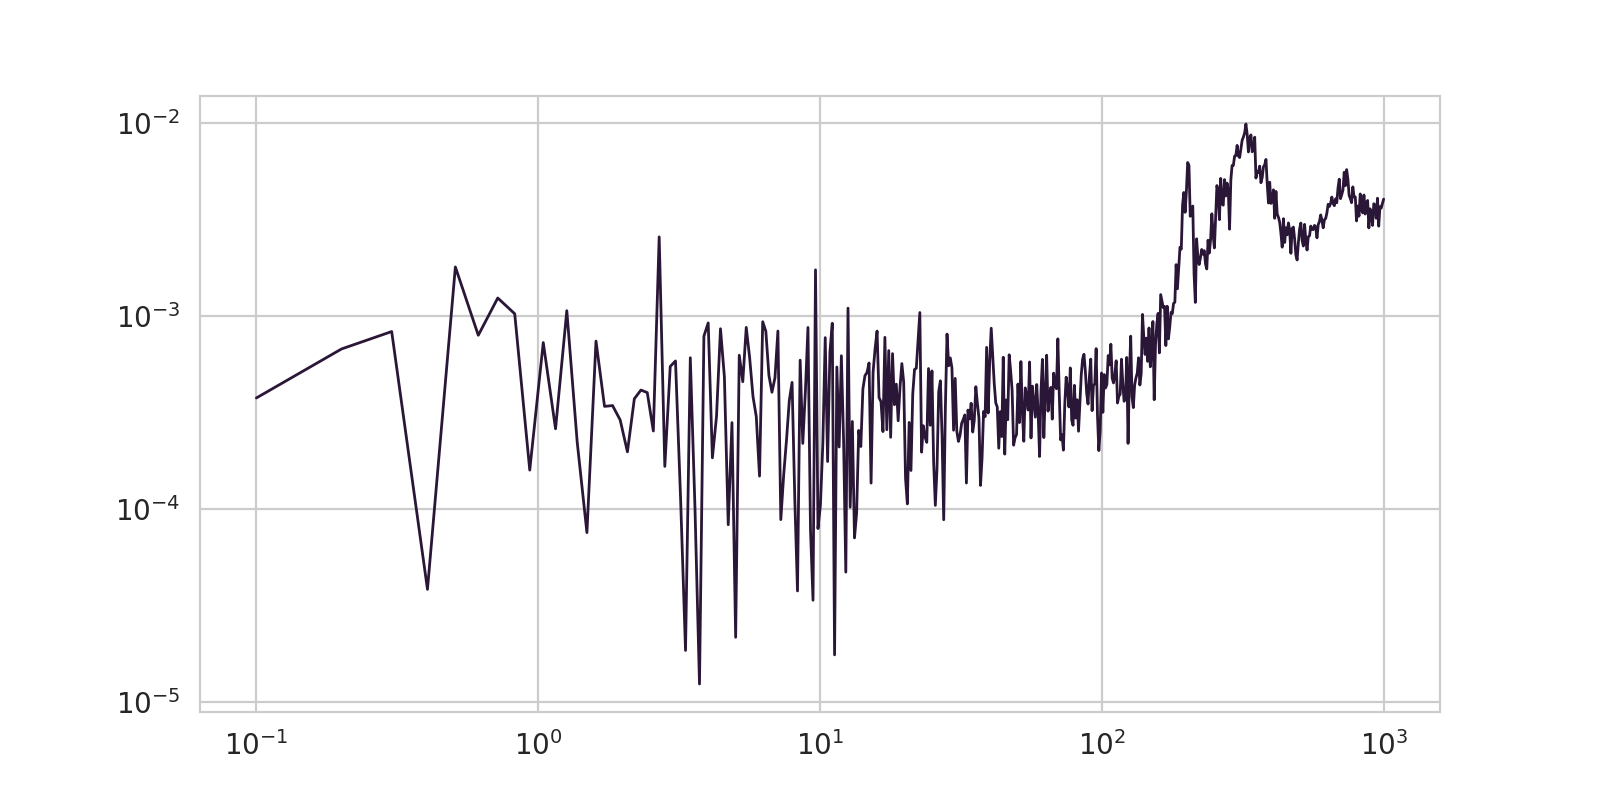

In [250]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(ps_log_dt.freq, test_data, lw=1)


Neural network successfully converged after 33 epochs.


<IPython.core.display.Javascript object>


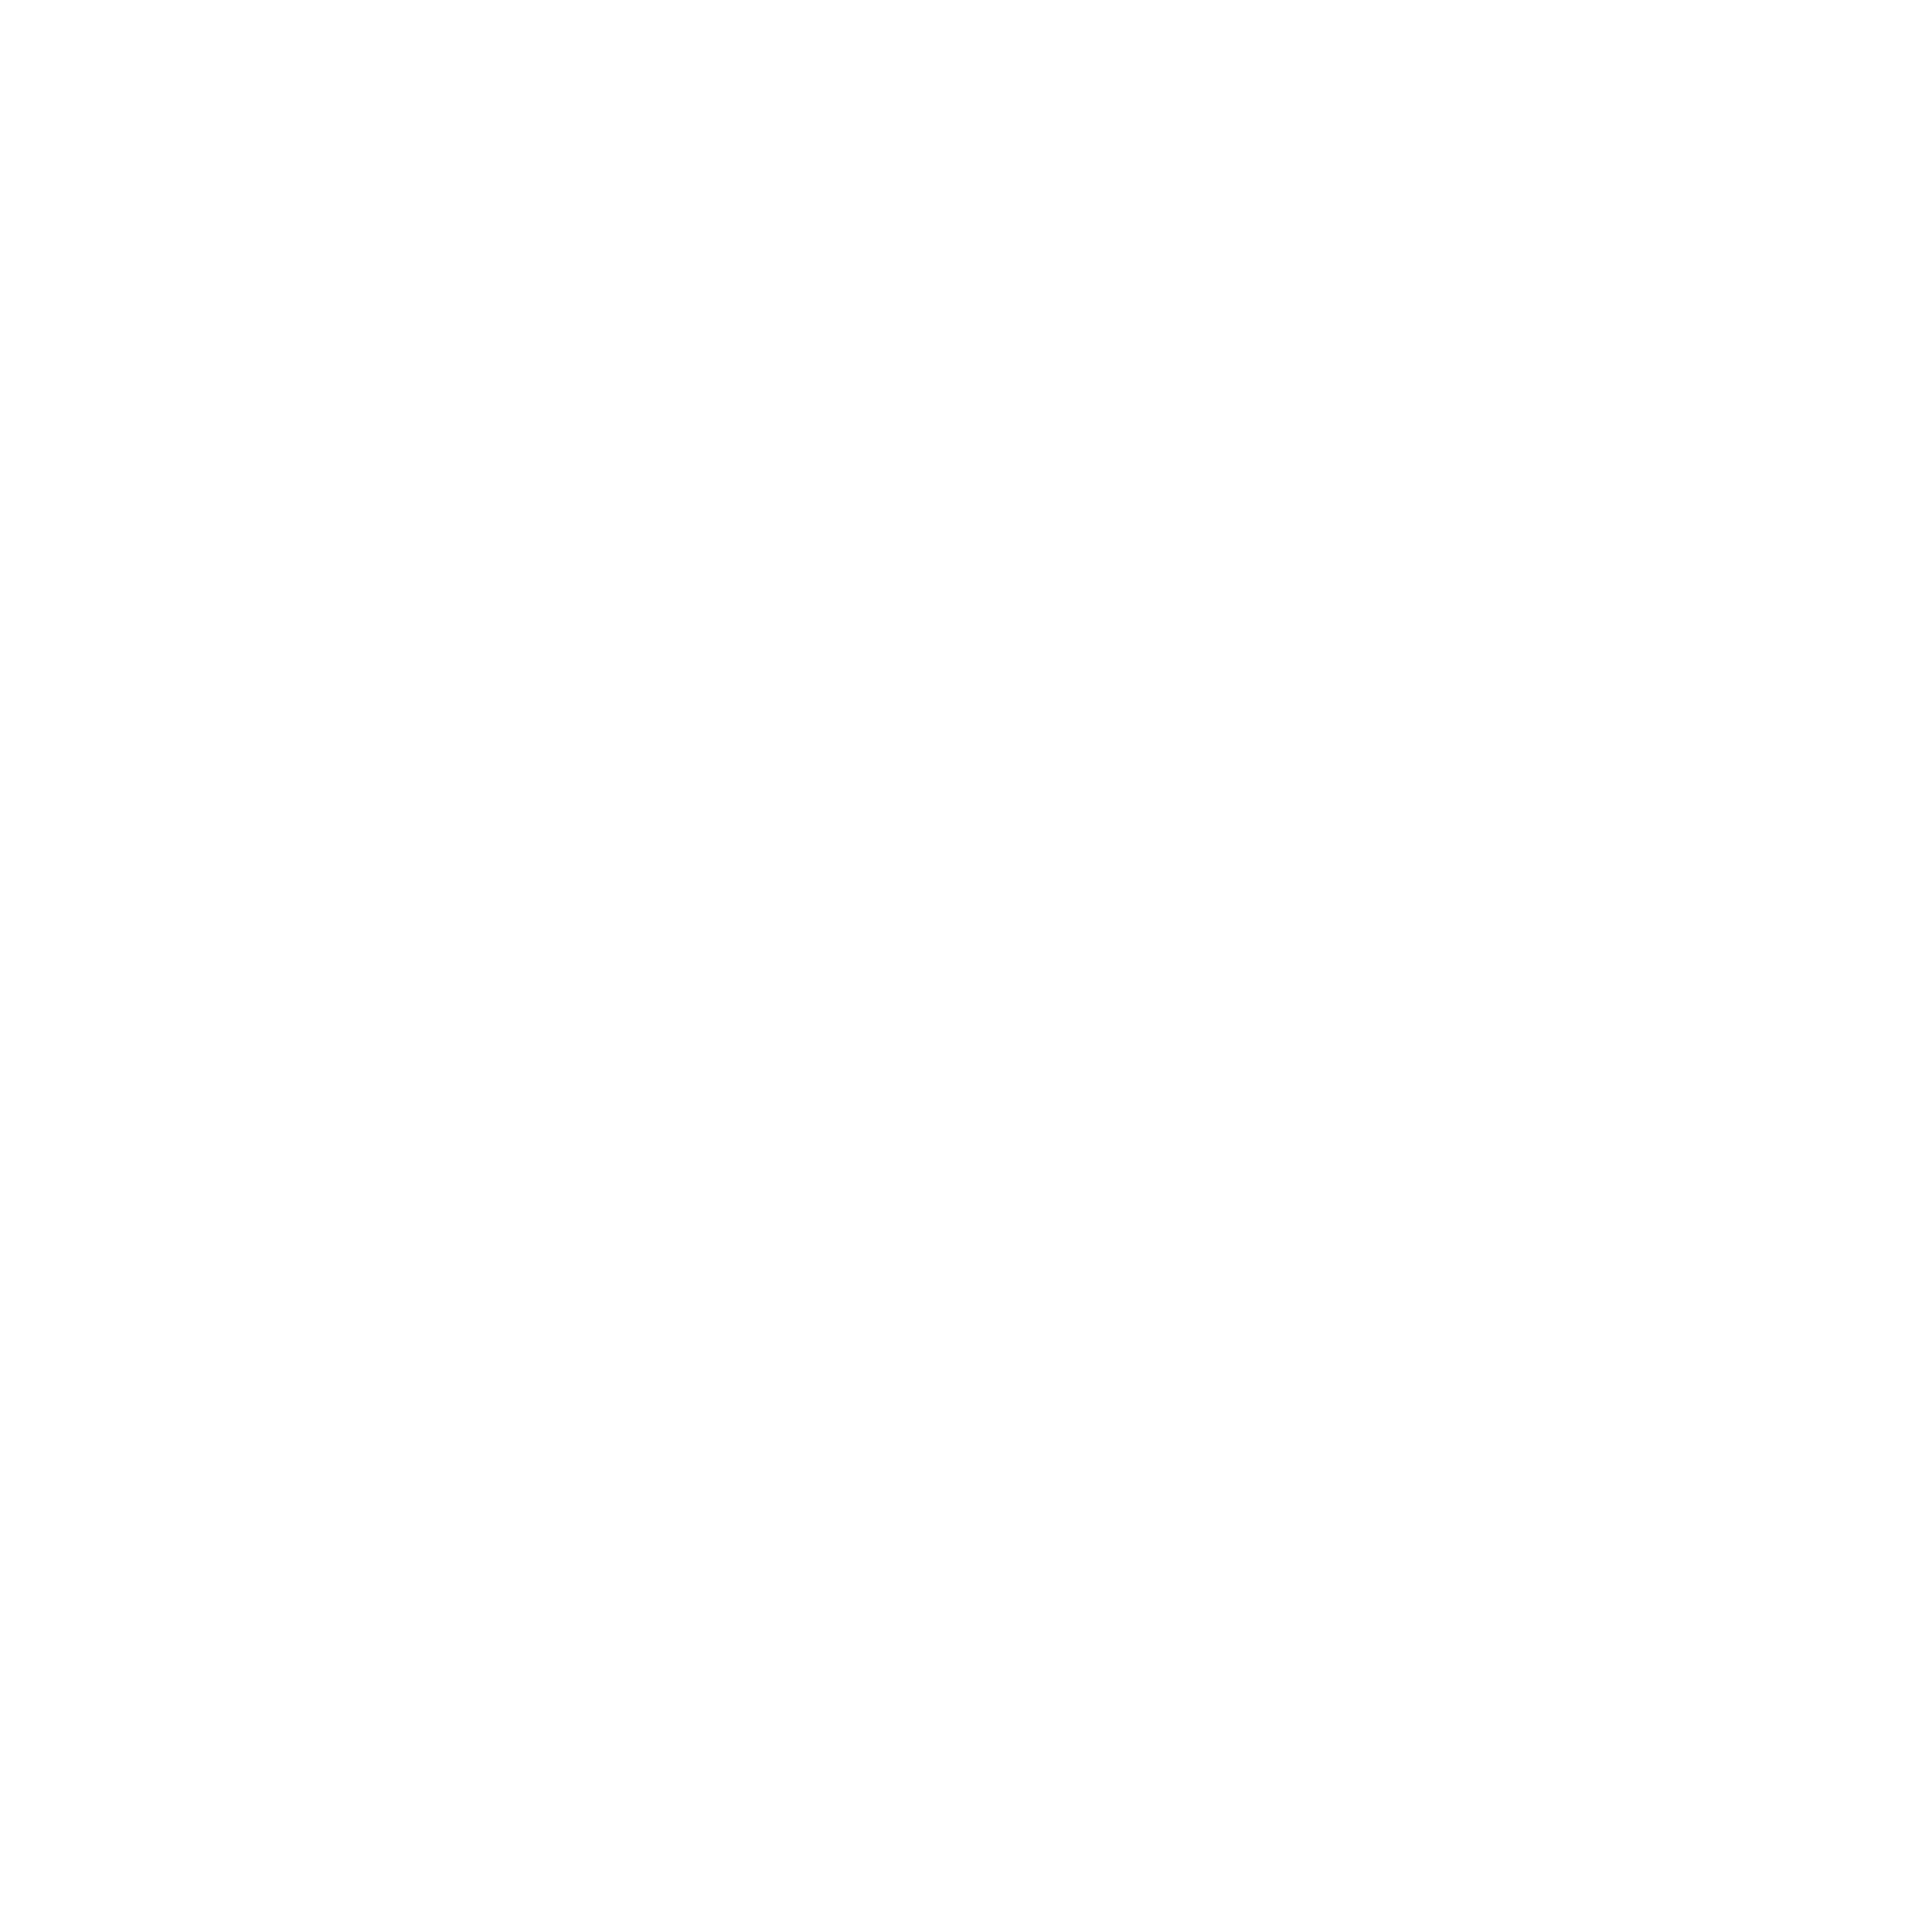

In [264]:
num_sim = 20000
method = "SNPE"

posterior = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

In [265]:
samples = posterior.sample((10000,), 
                           x=torch.as_tensor(ps_log_dt.power))

<IPython.core.display.Javascript object>


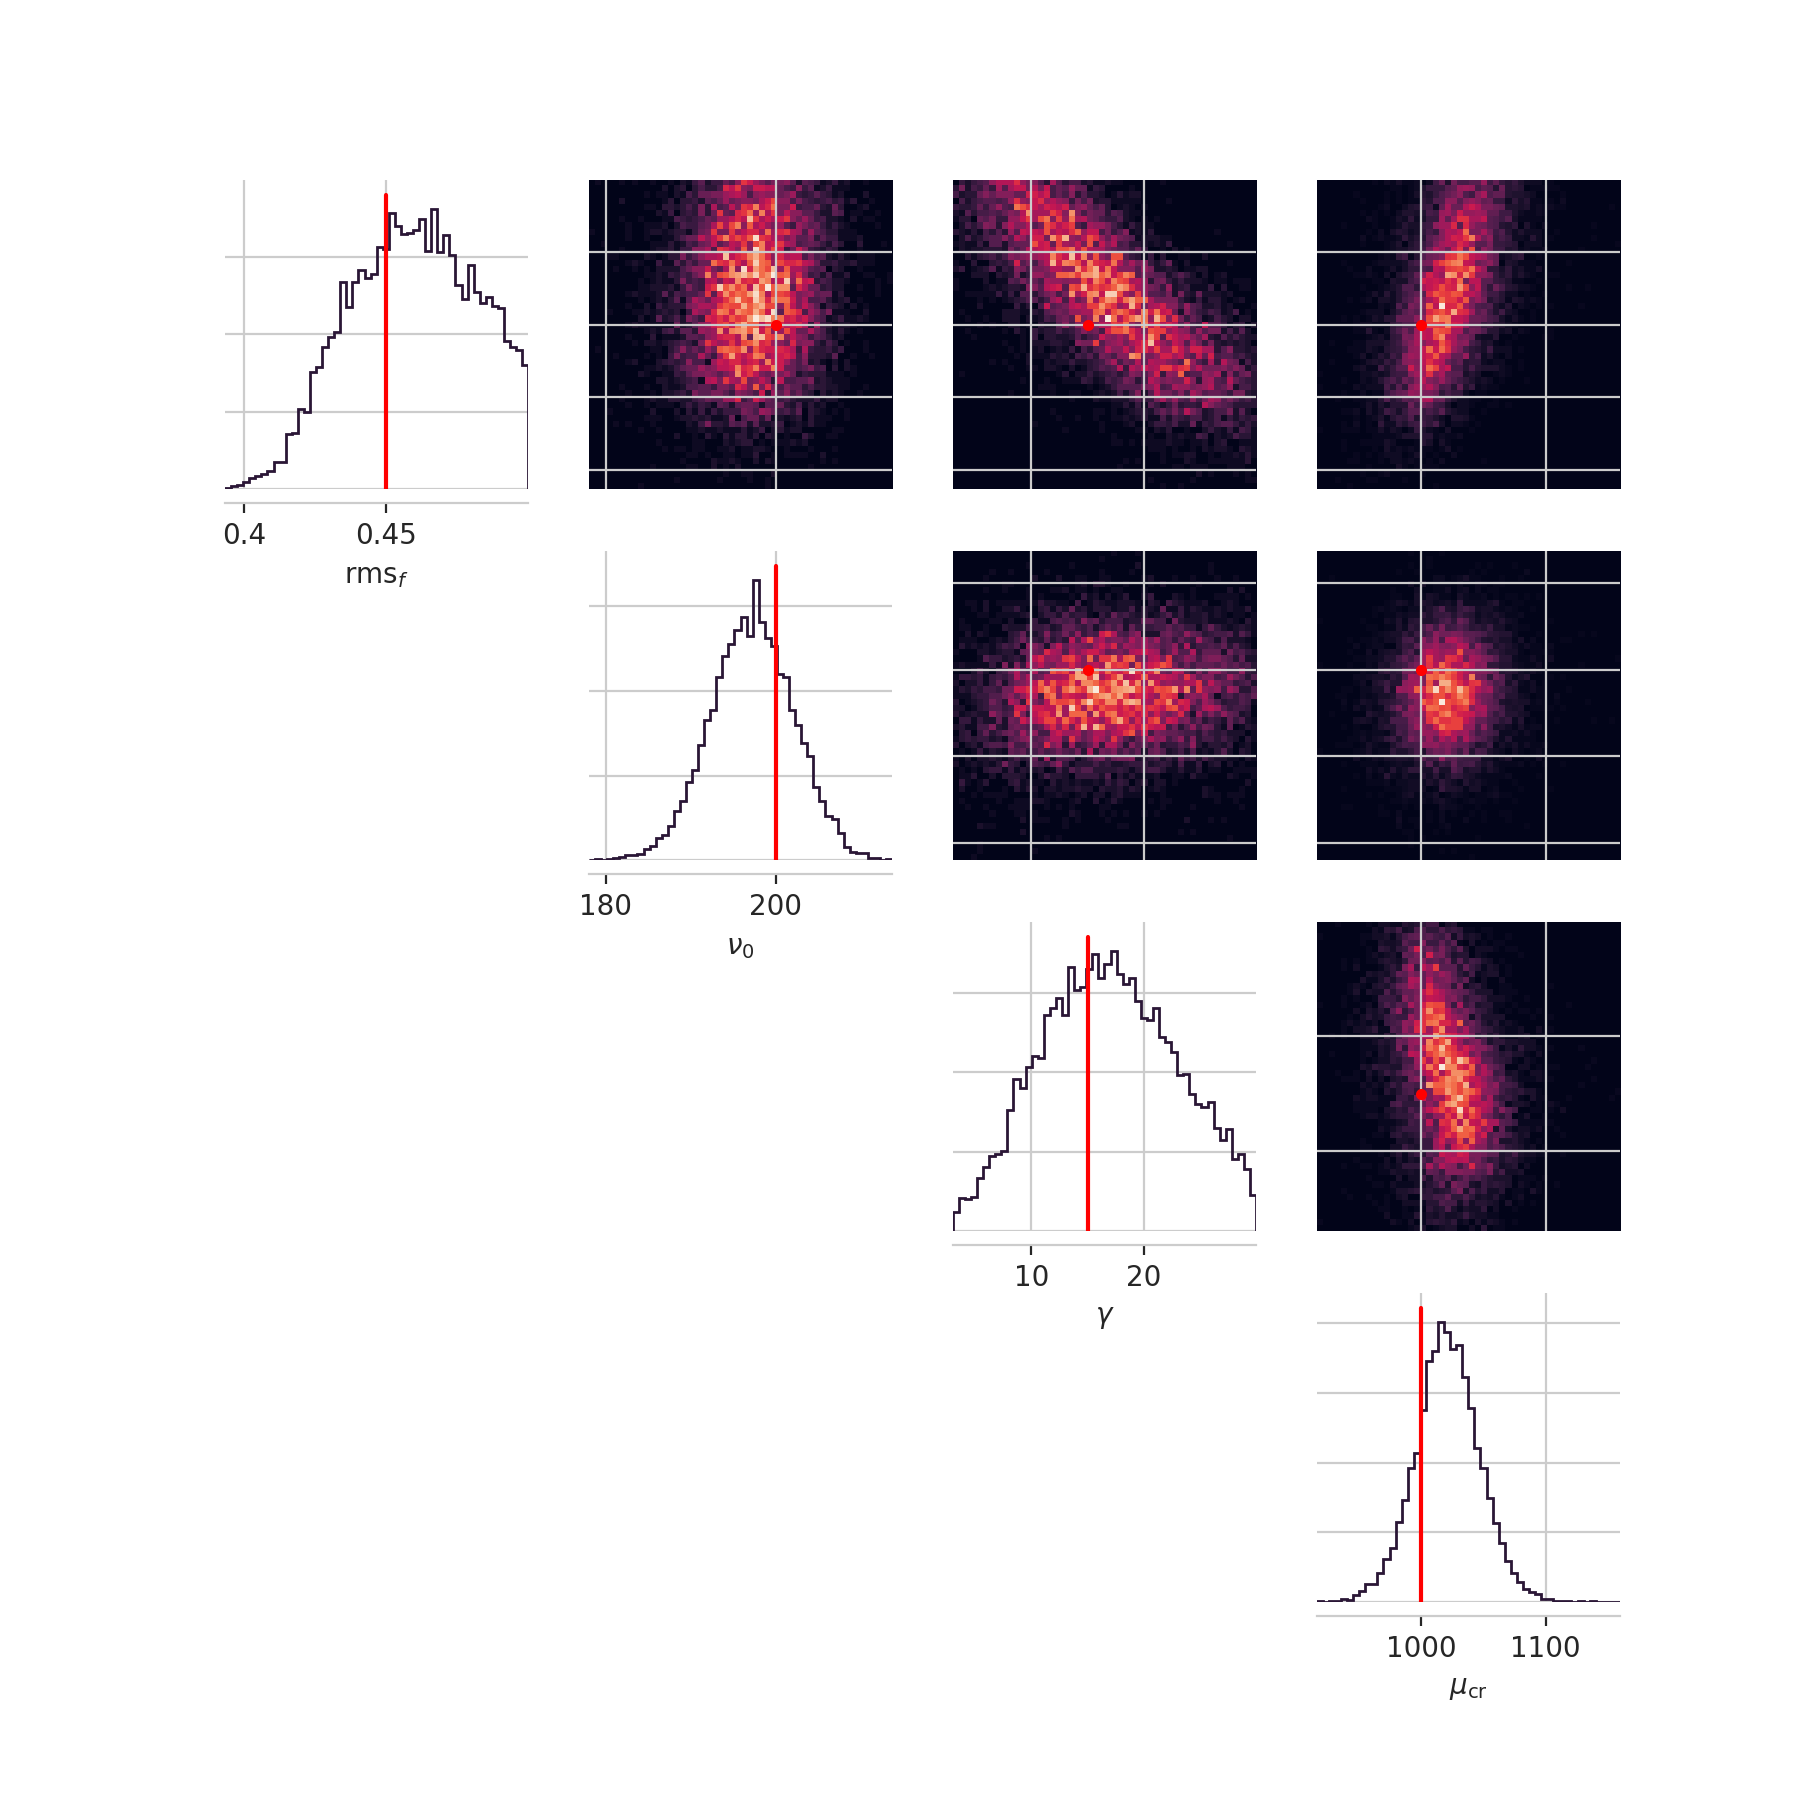

In [266]:
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           labels=param_names,
                           points_colors='r');


In [267]:
pal = sns.color_palette()

<IPython.core.display.Javascript object>


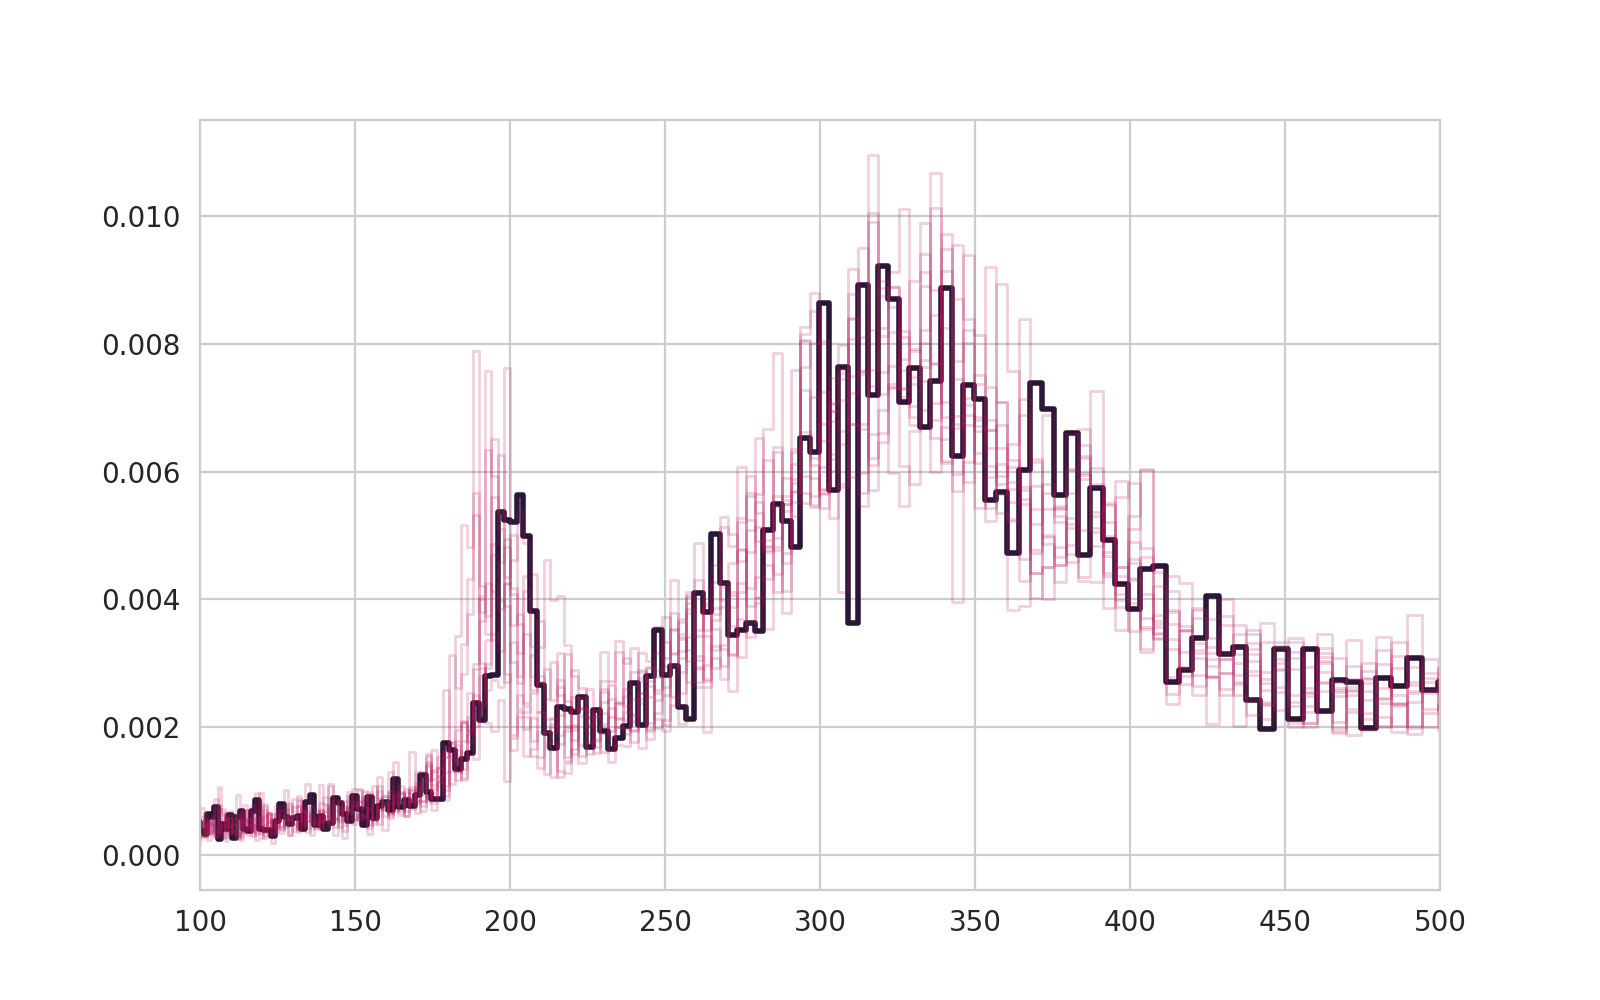

(100.0, 500.0)

In [268]:
samples = np.array(samples)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(ps_log_dt.freq, ps_log_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples[i,:]
    ps_sim = np.array(simulator(param_sim))
    
    ax.plot(ps_log_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    
ax.set_xlim(100, 500)